In [1]:
from setup import general
from setup import stat
from setup import r

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg
from pingouin import ancova # anconva
from pingouin import multivariate_normality # for pearson correlation
from rpy2 import robjects

In [2]:
general.pd_setup()

/home/jzni/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Analysis
利用前后配对的数据，相互之间做差值，对变化量进行相关性检验    
由于行为数据最多，以行为数据的ID为基准，筛选其他的数据

## 整合数据

In [3]:
# 配对的行为数据
%store -r SF_Paired
SF_Paired.head()

timepoint      VAS    SFMPQ     PDQ     PSQ  FPQ_Severe  FPQ_Mild  \
ID                                                                         
P_003          1  50.0000  96.0000 19.0000 41.0000     15.0000   16.0000   
P_003          2  40.0000  39.0000 17.0000     NaN         NaN       NaN   
P_004          1 100.0000 150.0000 34.0000     NaN         NaN       NaN   
P_004          2      NaN  85.0000 24.0000 93.0000     39.0000   23.0000   
P_007          1  60.0000 111.0000 21.0000     NaN         NaN       NaN   

       FPQ_Medical  FPQ_Total   PCS_1   PCS_2   PCS_3  PCS_Total    PASS  \
ID                                                                         
P_003      18.0000    49.0000 11.0000  8.0000 14.0000    33.0000 67.0000   
P_003          NaN        NaN     NaN     NaN     NaN        NaN     NaN   
P_004          NaN        NaN     NaN     NaN     NaN        NaN     NaN   
P_004      36.0000    98.0000 16.0000 11.0000 12.0000    39.0000 55.0000   
P_007          NaN        NaN     NaN     NaN     NaN        NaN     NaN   

         PVAQ     SAI     TAI    HAMA    HAMD     BDI   LOT_R    PSQI  
ID                                                                     
P_003 65.0000 22.0000 31.0000 17.0000 24.0000  4.0000 26.0000  4.0000  
P_003     NaN 22.0000     NaN  1.0000  2.0000  0.0000     NaN     NaN  
P_004     NaN 70.0000     NaN     NaN     NaN 19.0000     NaN     NaN  
P_004 52.0000     NaN 32.0000     NaN     NaN  7.0000 20.0000 16.0000  
P_007     NaN 68.0000     NaN 23.0000 13.0000 13.0000     NaN     NaN

In [4]:
%store -r patient_vbm patient_vbm_2
# 相应的vbm数据
patient_vbm.head()

BA9   BA44     M1    MTG  temporal_pole  r_thal
ID                                                      
P_013 0.2959 0.3109 0.3921 0.5179         0.4855  0.2494
P_014 0.3445 0.2375 0.3211 0.3846         0.4601  0.2915
P_015 0.2877 0.2541 0.3859 0.3627         0.4489  0.2738
P_016 0.3687 0.3338 0.4232 0.5243         0.4420  0.2654
P_018 0.3374 0.2128 0.3605 0.3274         0.4490  0.2833

In [5]:
%store -r patient_tbss patient_tbss_2
# 相应的dti数据
patient_tbss

corticospinal_l  external_capsule_l  \
subjectID                                        
P_014               0.1122              0.1347   
P_015               0.1128              0.1237   
P_016               0.1219              0.1418   
P_018               0.1178              0.1320   
P_019               0.1177              0.1421   
P_021               0.1208              0.1286   
P_022               0.1237              0.1427   
P_023               0.1184              0.1316   
P_024               0.1289              0.1490   
P_030               0.1239              0.1391   

           retrolenticular_internal_capsule_l  \
subjectID                                       
P_014                                  0.1917   
P_015                                  0.1905   
P_016                                  0.2082   
P_018                                  0.2007   
P_019                                  0.1972   
P_021                                  0.2053   
P_022                                  0.2157   
P_023                                  0.2172   
P_024                                  0.2261   
P_030                                  0.2185   

           retrolenticular_internal_capsule_r  sma_r  slf_l  slf_r  \
subjectID                                                            
P_014                                  0.1724 0.1231 0.0573 0.1085   
P_015                                  0.1833 0.1356 0.0608 0.1263   
P_016                                  0.1989 0.1375 0.0660 0.1351   
P_018                                  0.2043 0.1267 0.0624 0.1331   
P_019                                  0.1871 0.1404 0.0638 0.1331   
P_021                                  0.2036 0.1391 0.0659 0.1341   
P_022                                  0.2068 0.1407 0.0687 0.1393   
P_023                                  0.1936 0.1275 0.0637 0.1268   
P_024                                  0.2250 0.1417 0.0695 0.1433   
P_030                                  0.2114 0.1441 0.0689 0.1425   

           slf_temporal_l  slf_temporal_r  corticospinal_r  callosalbody  \
subjectID                                                                  
P_014              0.0777          0.0825           0.1089        0.0865   
P_015              0.0825          0.0932           0.1151        0.0907   
P_016              0.0898          0.0975           0.1245        0.0973   
P_018              0.0857          0.0963           0.1178        0.0911   
P_019              0.0859          0.0952           0.1208        0.0971   
P_021              0.0892          0.0970           0.1220        0.0932   
P_022              0.0935          0.1024           0.1243        0.1018   
P_023              0.0852          0.0942           0.1203        0.0956   
P_024              0.0950          0.1035           0.1291        0.1030   
P_030              0.0945          0.1007           0.1252        0.1024   

           forcepts_minor  
subjectID                  
P_014              0.0594  
P_015              0.0640  
P_016              0.0682  
P_018              0.0614  
P_019              0.0691  
P_021              0.0636  
P_022              0.0727  
P_023              0.0650  
P_024              0.0701  
P_030              0.0718

In [6]:
%store -r asia
#相应的临床量表数据
asia1 = asia[asia['timepoint']==1]
asia2 = asia[asia['timepoint']==2]

In [7]:
%store -r pt_sens pt1_sens pt_pain pt1_pain
# 相应的QST数据
qst_list = [pt_sens, pt1_sens, pt_pain, pt1_pain]
for df in qst_list:
    df.drop(['Type', 'tp', 'position'], inplace=True, axis = 1)
    
sens_cols = 'sens_' + pt_sens.columns 
pain_cols = 'pain_' + pt_pain.columns
pt_sens.columns = sens_cols
pt1_sens.columns = sens_cols
pt_pain.columns = pain_cols
pt1_pain.columns = pain_cols
pt_sens.head()

sens_c6  sens_c7  sens_c8  sens_head
ID                                         
P_003   0.5500   1.2250      NaN        NaN
P_004   0.5537      NaN   0.0925        NaN
P_006   0.0257      NaN   0.0633        NaN
P_007   0.2017      NaN   0.1240        NaN
P_007   0.1450      NaN   0.1100        NaN

In [8]:
# 前测的全部数据
tp1 = SF_Paired[SF_Paired['timepoint'].isin([1])].join(patient_vbm).join(patient_tbss,lsuffix="1").join(asia1,lsuffix="1").join(pt_sens).join(pt_pain).drop(['timepoint','timepoint1','name','time'],axis=1)
tp1

VAS    SFMPQ     PDQ      PSQ  FPQ_Severe  FPQ_Mild  FPQ_Medical  \
ID                                                                            
P_003  50.0000  96.0000 19.0000  41.0000     15.0000   16.0000      18.0000   
P_004 100.0000 150.0000 34.0000      NaN         NaN       NaN          NaN   
P_007  60.0000 111.0000 21.0000      NaN         NaN       NaN          NaN   
P_007  60.0000 111.0000 21.0000      NaN         NaN       NaN          NaN   
P_007  60.0000 111.0000 21.0000      NaN         NaN       NaN          NaN   
P_007  60.0000 111.0000 21.0000      NaN         NaN       NaN          NaN   
P_013  60.0000  65.0000 15.0000  66.0000         NaN       NaN          NaN   
P_014  80.0000  85.0000 15.0000  92.0000         NaN       NaN          NaN   
P_015  85.0000  78.0000 13.0000  53.0000     39.0000   27.0000      28.0000   
P_016  80.0000  94.0000 22.0000 129.0000         NaN       NaN          NaN   
P_018  10.0000  36.0000 10.0000  24.0000     13.0000   10.0000      11.0000   
P_019  50.0000  42.0000 21.0000  58.0000     26.0000   15.0000      22.0000   
P_020  40.0000  48.0000 13.0000  83.0000     36.0000   17.0000      25.0000   
P_022  80.0000 107.0000 36.0000 108.0000     43.0000   32.0000      41.0000   
P_024  60.0000  56.0000 14.0000  37.0000     19.0000   15.0000      18.0000   

       FPQ_Total   PCS_1  PCS_2   PCS_3  PCS_Total    PASS    PVAQ     SAI  \
ID                                                                           
P_003    49.0000 11.0000 8.0000 14.0000    33.0000 67.0000 65.0000 22.0000   
P_004        NaN     NaN    NaN     NaN        NaN     NaN     NaN 70.0000   
P_007        NaN     NaN    NaN     NaN        NaN     NaN     NaN 68.0000   
P_007        NaN     NaN    NaN     NaN        NaN     NaN     NaN 68.0000   
P_007        NaN     NaN    NaN     NaN        NaN     NaN     NaN 68.0000   
P_007        NaN     NaN    NaN     NaN        NaN     NaN     NaN 68.0000   
P_013        NaN     NaN    NaN     NaN        NaN     NaN     NaN 34.0000   
P_014        NaN     NaN    NaN     NaN        NaN     NaN     NaN 47.0000   
P_015    94.0000  6.0000 2.0000  2.0000    10.0000 27.0000 40.0000     NaN   
P_016        NaN  6.0000 3.0000  1.0000    10.0000     NaN     NaN 43.0000   
P_018    34.0000  1.0000 0.0000  1.0000     2.0000  5.0000 26.0000 24.0000   
P_019    63.0000  6.0000 6.0000 10.0000    22.0000 47.0000 48.0000 32.0000   
P_020    78.0000  5.0000 5.0000 14.0000    24.0000 38.0000 36.0000 41.0000   
P_022   116.0000  7.0000 2.0000 13.0000    22.0000 45.0000 32.0000 37.0000   
P_024    52.0000  8.0000 1.0000  3.0000    12.0000 10.0000 26.0000 20.0000   

          TAI    HAMA    HAMD     BDI   LOT_R   PSQI    BA9   BA44     M1  \
ID                                                                          
P_003 31.0000 17.0000 24.0000  4.0000 26.0000 4.0000    NaN    NaN    NaN   
P_004     NaN     NaN     NaN 19.0000     NaN    NaN    NaN    NaN    NaN   
P_007     NaN 23.0000 13.0000 13.0000     NaN    NaN    NaN    NaN    NaN   
P_007     NaN 23.0000 13.0000 13.0000     NaN    NaN    NaN    NaN    NaN   
P_007     NaN 23.0000 13.0000 13.0000     NaN    NaN    NaN    NaN    NaN   
P_007     NaN 23.0000 13.0000 13.0000     NaN    NaN    NaN    NaN    NaN   
P_013     NaN 10.0000 13.0000 20.0000     NaN    NaN 0.2959 0.3109 0.3921   
P_014     NaN  9.0000  9.0000 17.0000     NaN    NaN 0.3445 0.2375 0.3211   
P_015 34.0000  4.0000  2.0000  7.0000 19.0000 6.0000 0.2877 0.2541 0.3859   
P_016     NaN  3.0000  4.0000  3.0000     NaN 5.0000 0.3687 0.3338 0.4232   
P_018 31.0000  1.0000  0.0000  3.0000 22.0000 7.0000 0.3374 0.2128 0.3605   
P_019 35.0000  0.0000  0.0000  4.0000 22.0000 7.0000 0.2919 0.3233 0.3695   
P_020 33.0000  0.0000  0.0000  3.0000 17.0000 4.0000    NaN    NaN    NaN   
P_022 39.0000  6.0000  2.0000  7.0000 22.0000 4.0000 0.3565 0.3360 0.4501   
P_024 30.0000  0.0000  0.0000  3.0000 23.0000 3.0000 0.3744 0.3306 0.4254   

         MTG  temporal_pole  r

In [9]:
# 后测的全部数据
tp2 = SF_Paired[SF_Paired['timepoint'].isin([2])].join(patient_vbm_2).join(patient_tbss_2,lsuffix="1").join(asia2,lsuffix="1").join(pt1_sens).join(pt1_pain).drop(['timepoint','timepoint1','name','time'],axis=1)

In [10]:
# 配对数据
test = tp2 -tp1
paired = test.index

In [11]:
# 配对数据缺失情况
pd.DataFrame(round(test.isnull().sum()/len(paired),2),columns=['缺少配对的百分比']).T

VAS  SFMPQ    PDQ    PSQ  FPQ_Severe  FPQ_Mild  FPQ_Medical  \
缺少配对的百分比 0.6500 0.0000 0.0000 0.7400      0.8400    0.8400       0.8400   

          FPQ_Total  PCS_1  PCS_2  PCS_3  PCS_Total   PASS   PVAQ    SAI  \
缺少配对的百分比     0.8400 0.7700 0.7700 0.7700     0.7700 0.8400 0.8100 0.6800   

            TAI   HAMA   HAMD    BDI  LOT_R   PSQI    BA9   BA44     M1  \
缺少配对的百分比 0.8700 0.0600 0.0600 0.0000 0.8700 0.7700 0.8400 0.8400 0.8400   

            MTG  temporal_pole  r_thal  corticospinal_l  external_capsule_l  \
缺少配对的百分比 0.8400         0.8400  0.8400           0.8700              0.8700   

          retrolenticular_internal_capsule_l  \
缺少配对的百分比                              0.8700   

          retrolenticular_internal_capsule_r  sma_r  slf_l  slf_r  \
缺少配对的百分比                              0.8700 0.8700 0.8700 0.8700   

          slf_temporal_l  slf_temporal_r  corticospinal_r  callosalbody  \
缺少配对的百分比          0.8700          0.8700           0.8700        0.8700   

          forcepts_minor  asia_motor  asia_sensory  scimIII_1  scimIII_2  \
缺少配对的百分比          0.8700      0.0000        0.0000     0.1300     0.1300   

          scimIII_3  scimIII_total  wisciII  sens_c6  sens_c7  sens_c8  \
缺少配对的百分比     0.1300         0.1300   0.1300   0.0600   0.6500   0.1900   

          sens_head  pain_c6  pain_c7  pain_c8  pain_head  
缺少配对的百分比     0.9400   0.1900   0.7700   0.1900     0.9400

**SFMPQ， PDQ， HAMA，HAMD，BDI缺失相对较少**

# Correlation
## 部分数据
挑选缺失值较少的部分数据进行分析

In [12]:
items = ['SFMPQ', 'PDQ','HAMA', 'HAMD', 'BDI']
items.extend(test.columns[-15:])
items.remove('sens_head')
items.remove('pain_head')
df1 = test.loc[:,items]
df1['scimIII_total'] = df1['scimIII_total'].astype('float')

(18, 18)


<AxesSubplot:>

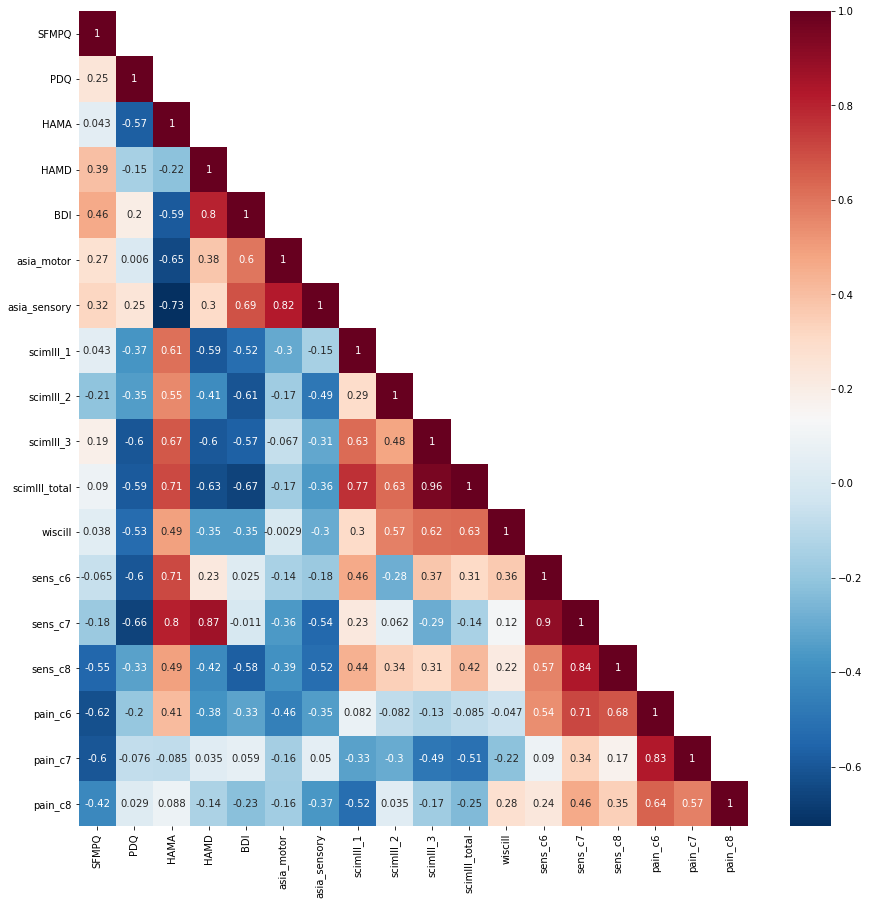

In [13]:
# 制作三角形的热图
mask = np.zeros_like(df1.corr())
print(mask.shape)
for i in range(len(mask)):
    for j in range(i+1, len(mask[0])):
        mask[i][j] = True
plt.figure(figsize=(15,15))
sns.heatmap(df1.corr(),cmap="RdBu_r",annot=True, mask=mask)

In [14]:
def set_matrix_value(matrix,x_label, y_label, value):
    matrix.loc[x_label,y_label] = value
    matrix.loc[y_label,x_label] = value
        
index = df1.columns
rows = len(df1.columns)
cols = rows
# Patients' correlation matrix
vbm_coefficient_matrix = pd.DataFrame(np.zeros(rows*cols).reshape(rows,cols),  index=index,columns=index)
vbm_p_matrix = pd.DataFrame(np.zeros(rows*cols).reshape(rows,cols), index=index,columns=index)
vbm_norm_matrix = vbm_p_matrix.copy()



for scale in df1.columns:
    x_label = scale
    for y_label in df1.columns:
        if x_label == y_label:
            continue
            
        df = df1[[x_label, y_label]]
        df = df.dropna(how='any',axis=0) # drop any row with missing value

        norm_bool = 1 if multivariate_normality(df[[x_label, y_label]])[2] else 0
        set_matrix_value(vbm_norm_matrix, x_label, y_label, norm_bool)
        if norm_bool:
            pccs = stats.pearsonr(df[x_label], df[y_label])
        else:
            pccs = stats.spearmanr(df[x_label], df[y_label])      
        set_matrix_value(vbm_coefficient_matrix, x_label, y_label, round(pccs[0],4))
        set_matrix_value(vbm_p_matrix, x_label, y_label, round(pccs[1],4))

     

(18, 18)


<AxesSubplot:>

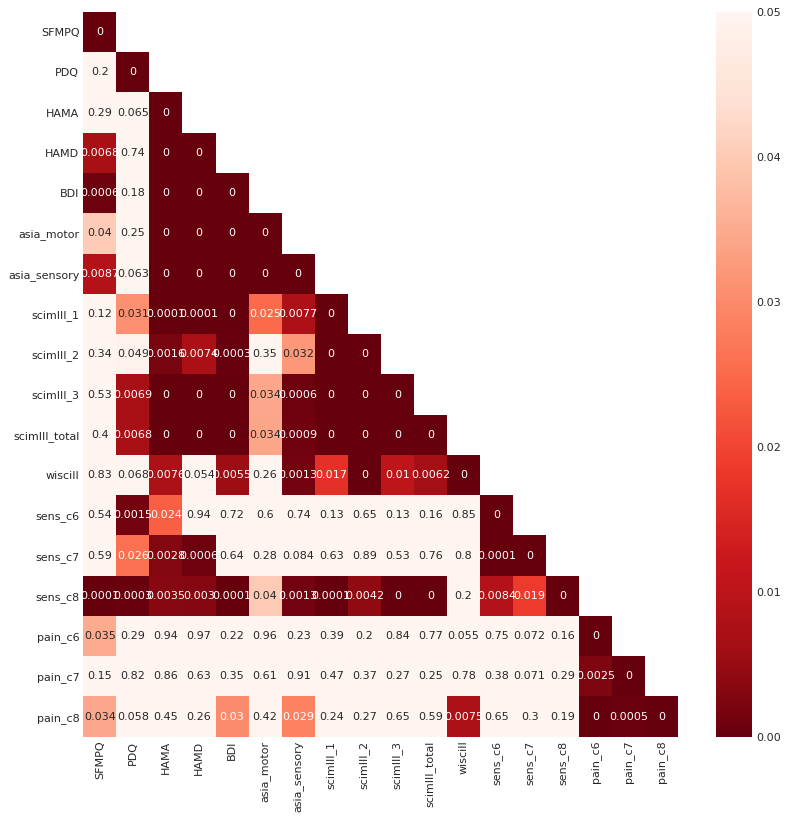

In [15]:
plt.figure(figsize=(12,12), dpi= 80)

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False 
mask = np.zeros_like(vbm_p_matrix)
print(mask.shape)
for i in range(len(mask)):
    for j in range(i+1, len(mask[0])):
        mask[i][j] = True
sns.heatmap(vbm_p_matrix, cmap='Reds_r',mask = mask, vmax=0.05, annot=True)

(18, 18)


<AxesSubplot:>

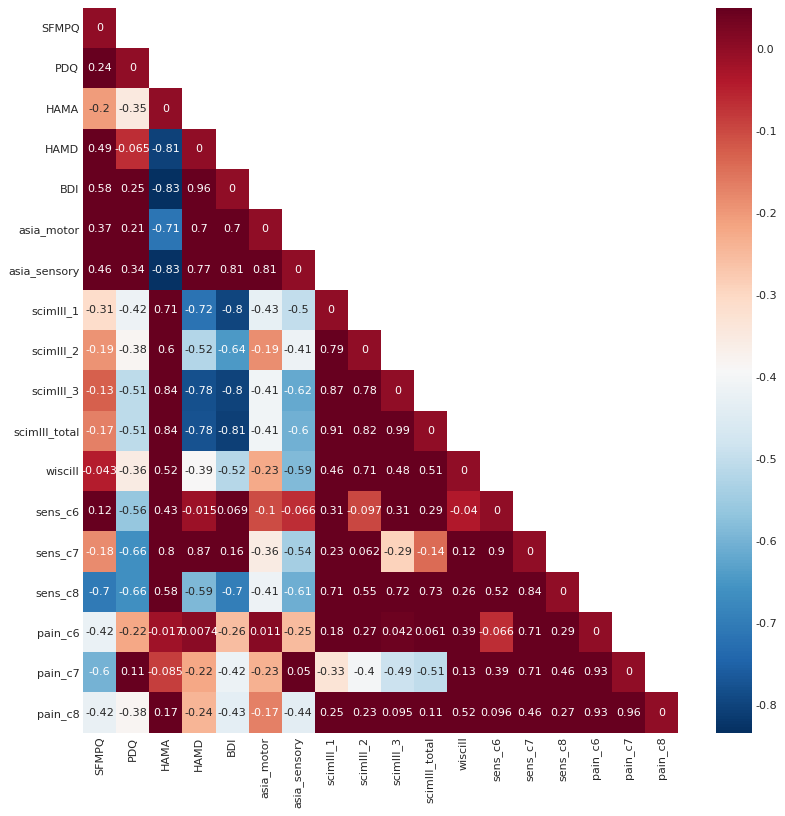

In [16]:
plt.figure(figsize=(12,12), dpi= 80)

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False 
mask = np.zeros_like(vbm_p_matrix)
print(mask.shape)
for i in range(len(mask)):
    for j in range(i+1, len(mask[0])):
        mask[i][j] = True
sns.heatmap(vbm_coefficient_matrix, cmap='RdBu_r',mask = mask, vmax=0.05, annot=True)

HAMD SFMPQ


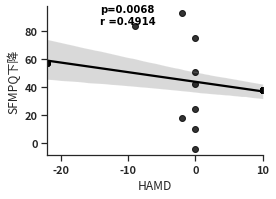

HAMD HAMA


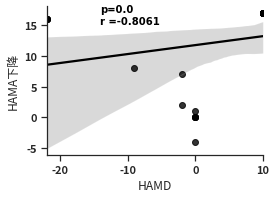

BDI SFMPQ


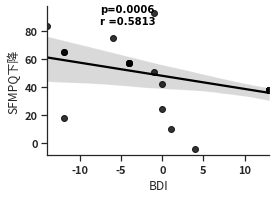

BDI HAMA


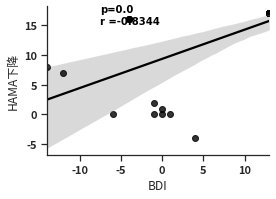

BDI HAMD


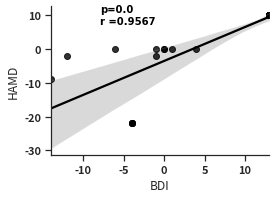

asia_motor SFMPQ


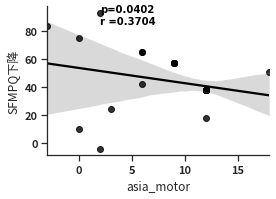

asia_motor HAMA


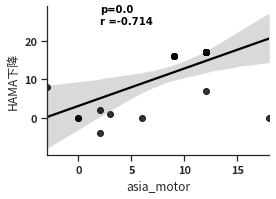

asia_motor HAMD


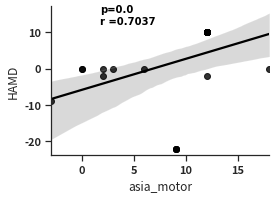

asia_motor BDI


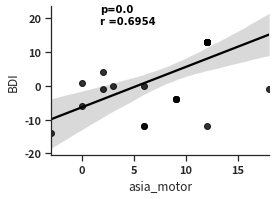

asia_sensory SFMPQ


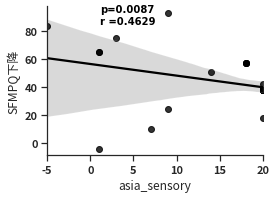

asia_sensory HAMA


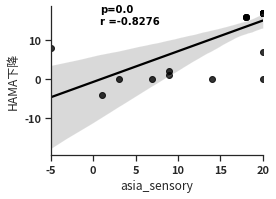

asia_sensory HAMD


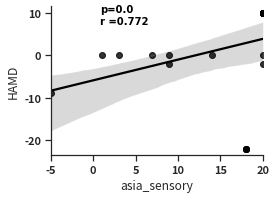

asia_sensory BDI


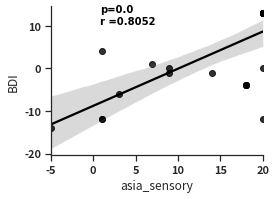

asia_sensory asia_motor


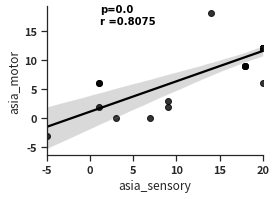

scimIII_1 PDQ


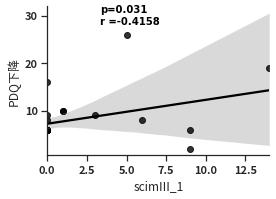

scimIII_1 HAMA


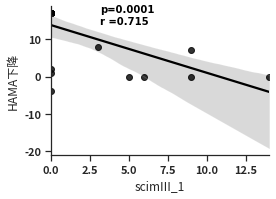

scimIII_1 HAMD


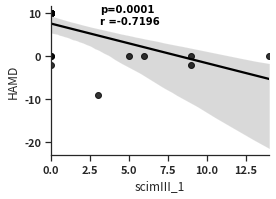

scimIII_1 BDI


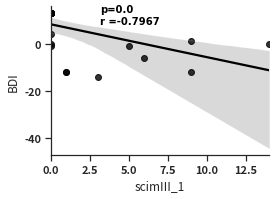

scimIII_1 asia_motor


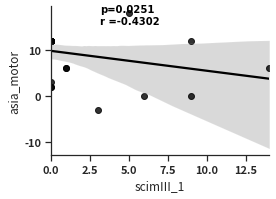

scimIII_1 asia_sensory


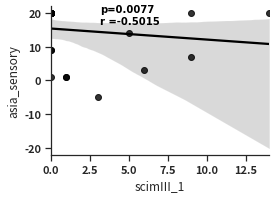

scimIII_2 PDQ


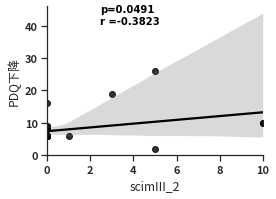

scimIII_2 HAMA


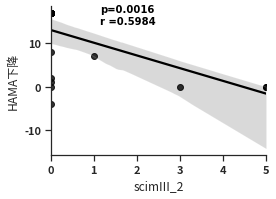

scimIII_2 HAMD


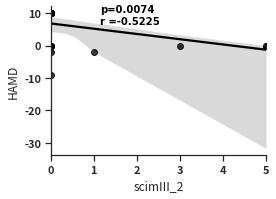

scimIII_2 BDI


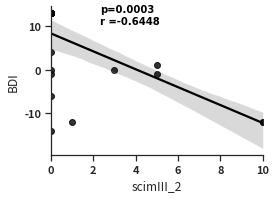

scimIII_2 asia_sensory


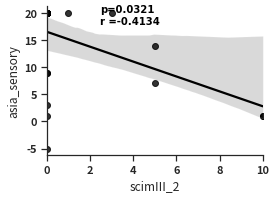

scimIII_2 scimIII_1


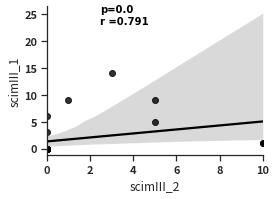

scimIII_3 PDQ


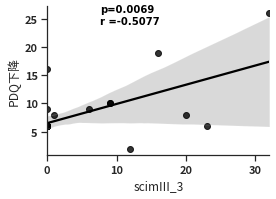

scimIII_3 HAMA


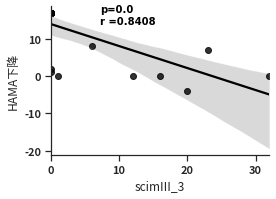

scimIII_3 HAMD


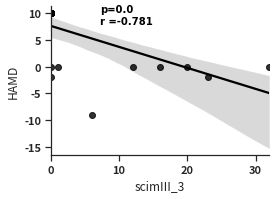

scimIII_3 BDI


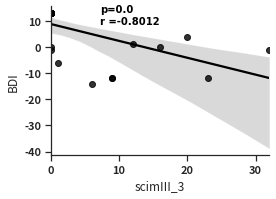

scimIII_3 asia_motor


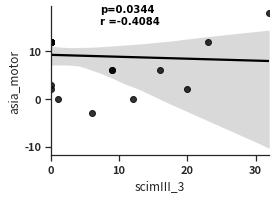

scimIII_3 asia_sensory


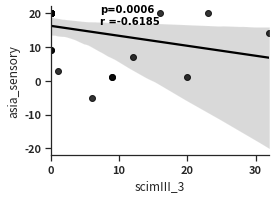

scimIII_3 scimIII_1


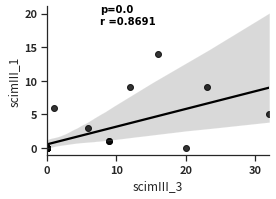

scimIII_3 scimIII_2


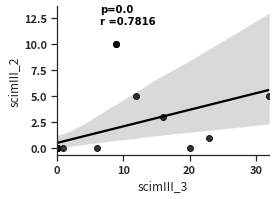

scimIII_total PDQ


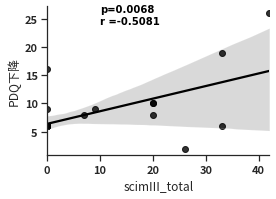

scimIII_total HAMA


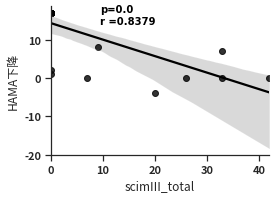

scimIII_total HAMD


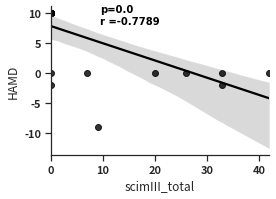

scimIII_total BDI


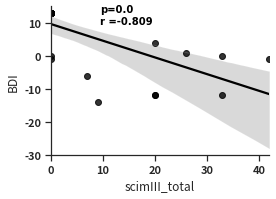

scimIII_total asia_motor


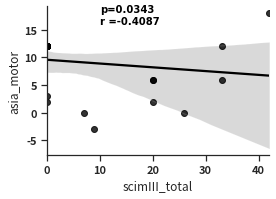

scimIII_total asia_sensory


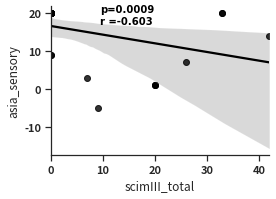

scimIII_total scimIII_1


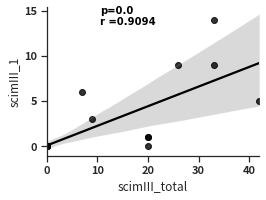

scimIII_total scimIII_2


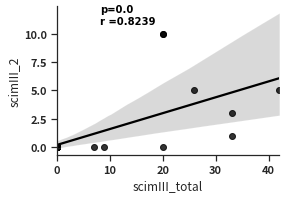

scimIII_total scimIII_3


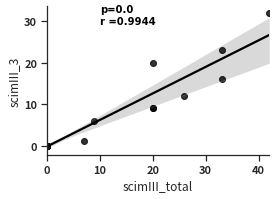

wisciII HAMA


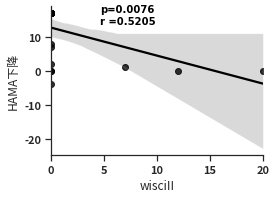

wisciII BDI


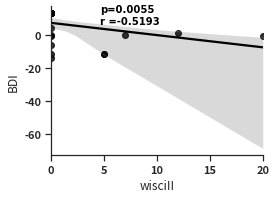

wisciII asia_sensory


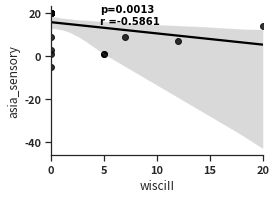

wisciII scimIII_1


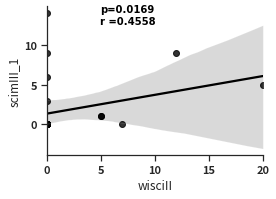

wisciII scimIII_2


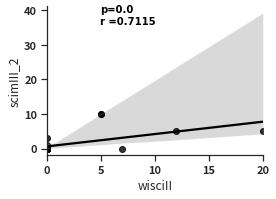

wisciII scimIII_3


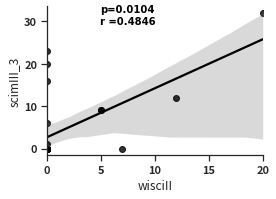

wisciII scimIII_total


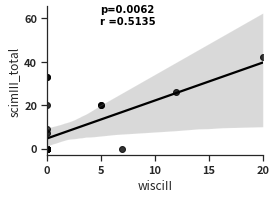

sens_c6 PDQ


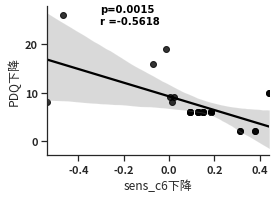

sens_c6 HAMA


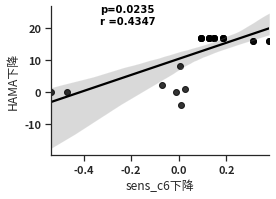

sens_c7 PDQ


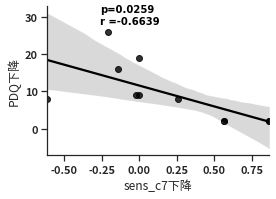

sens_c7 HAMA


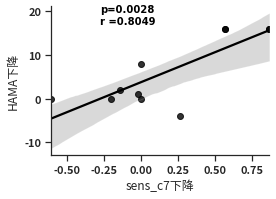

sens_c7 HAMD


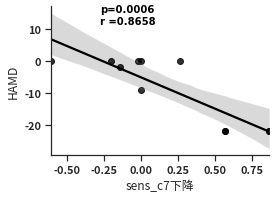

sens_c7 sens_c6


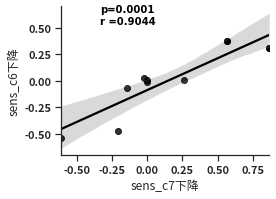

sens_c8 SFMPQ


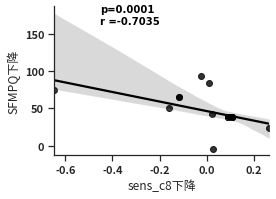

sens_c8 PDQ


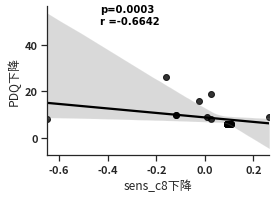

sens_c8 HAMA


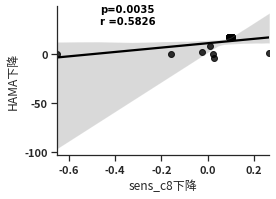

sens_c8 HAMD


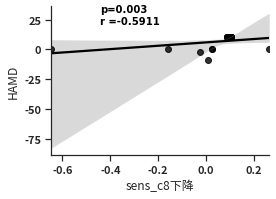

sens_c8 BDI


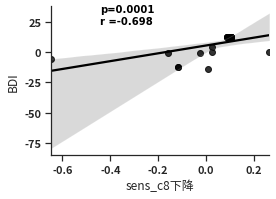

sens_c8 asia_motor


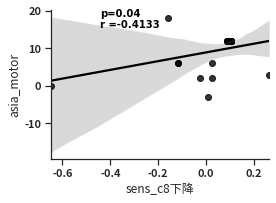

sens_c8 asia_sensory


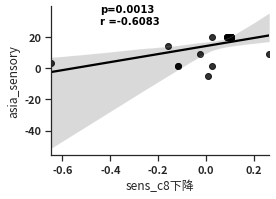

sens_c8 scimIII_1


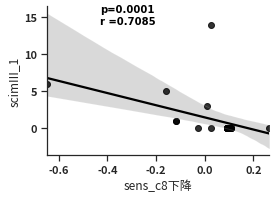

sens_c8 scimIII_2


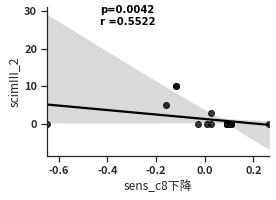

sens_c8 scimIII_3


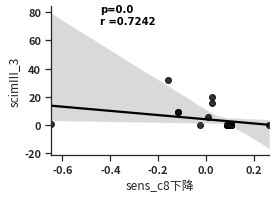

sens_c8 scimIII_total


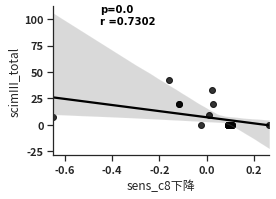

sens_c8 sens_c6


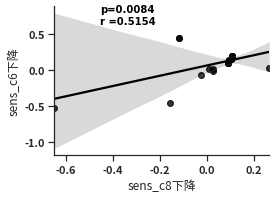

sens_c8 sens_c7


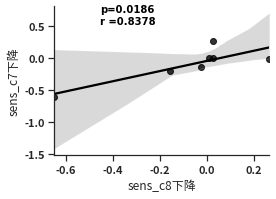

pain_c6 SFMPQ


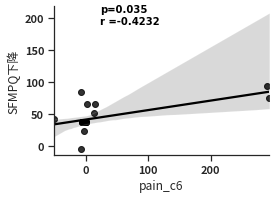

pain_c7 pain_c6


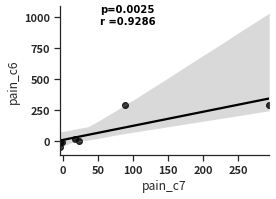

pain_c8 SFMPQ


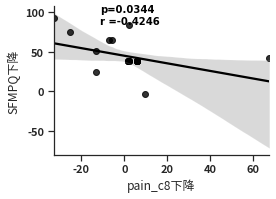

pain_c8 BDI


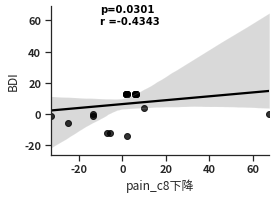

pain_c8 asia_sensory


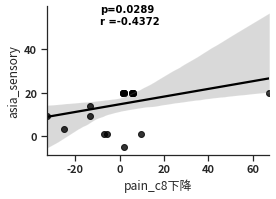

pain_c8 wisciII


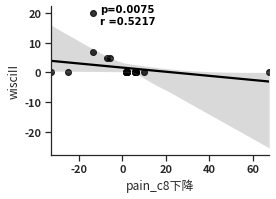

pain_c8 pain_c6


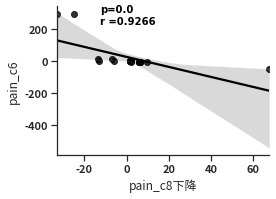

pain_c8 pain_c7


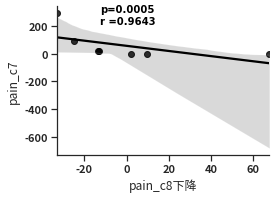

In [17]:
for i, scale in enumerate(df1.columns):
    x_label = scale
    for j in range(i):
        y_label = df1.columns[j]
        if x_label == y_label:
            continue
        if vbm_p_matrix.loc[y_label, x_label] < 0.05:

                plt.figure(figsize=(4,3))
                '''decorate image'''
                sns.set(font_scale=1)
                sns.set_style("white")
                plt.rcParams["font.weight"] = "bold"
                plt.rcParams["font.family"] = 'Noto Sans CJK JP'

                ax = plt.gca()      #gca='get current axis'
                # 将右边和上边的边框（脊）的颜色去掉
                ax.spines['right'].set_color('none')
                ax.spines['top'].set_color('none')

                # 绑定x轴和y轴
                font2 = {'weight' : 'normal','size'   : 10, }

                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                sns.set(color_codes=True)
                print(x_label,y_label)
                df_plot = df1[[x_label, y_label]]
                y_axes = '' ; x_axes=''
                if df_plot[y_label].mean() < 0:
                    y_axes = '{}下降'.format(y_label)
                    df_plot[y_label] = - df_plot[y_label]
                if df_plot[x_label].mean() < 0:
                    x_axes = '{}下降'.format(x_label)
                    df_plot[x_label] = - df_plot[x_label]

                sns.regplot(x=x_label, y=y_label, data=df_plot,color='black')
                if x_axes:
                    plt.xlabel(x_axes) 
                if y_axes:
                    plt.ylabel(y_axes)
                
                if pccs[0] <= 0:
                    plt.annotate("p ={}\nr={}".format(round(vbm_p_matrix.loc[y_label, x_label],4),vbm_coefficient_matrix.loc[y_label, x_label])
                             , xy=(200, 175), xycoords='figure points',fontsize=10,color="black")
                else:
                    plt.annotate("p={}\nr ={}".format(round(vbm_p_matrix.loc[y_label, x_label],4),vbm_coefficient_matrix.loc[y_label, x_label])
                             , xy=(100, 175), xycoords='figure points',fontsize=10,color="black")
                plt.tight_layout()

                plt.show()

<font size=8><mark>单从统计结果来看，有一部分显著的相关性，但拟合效果一般，实际意义难以肯定</mark></font>

## 全部数据

(53, 53)


<AxesSubplot:>

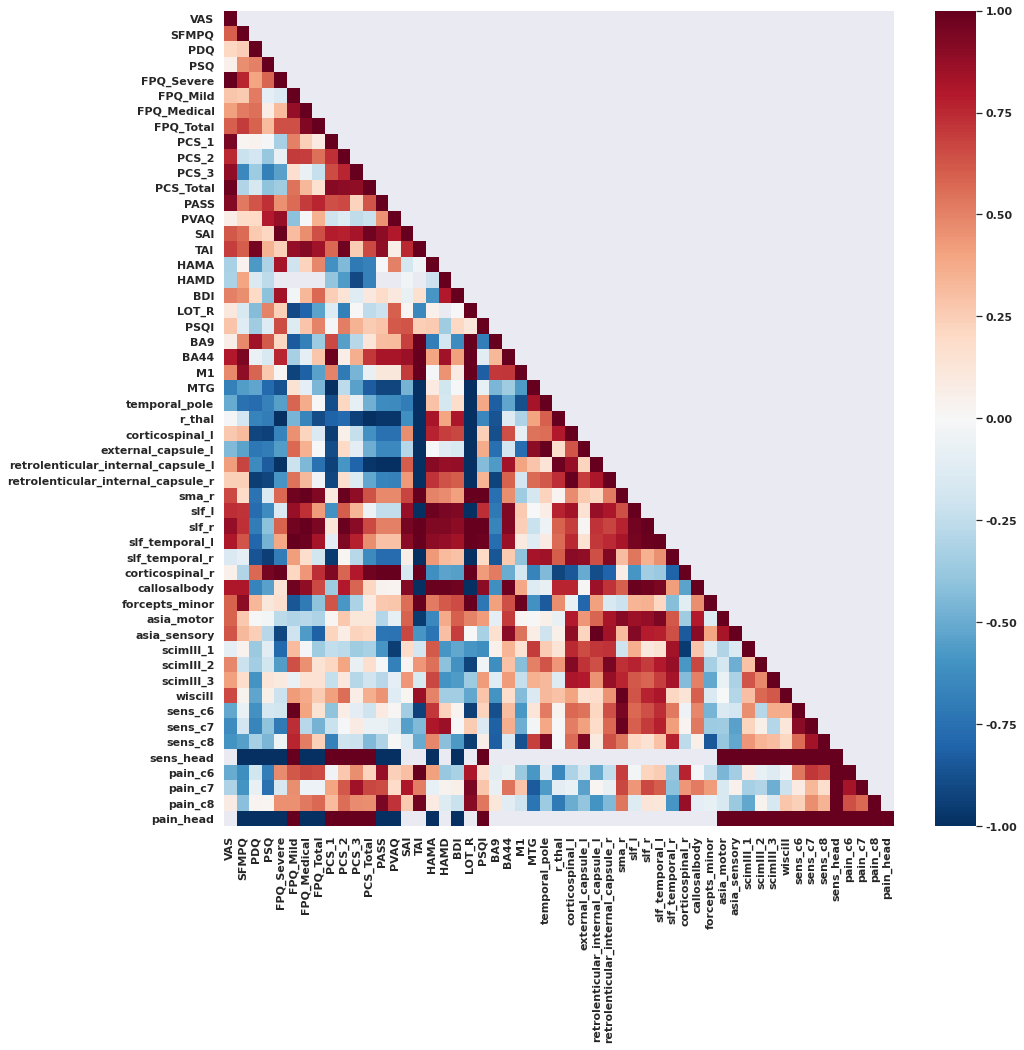

In [18]:
test
mask = np.zeros_like(test.corr())
print(mask.shape)
for i in range(len(mask)):
    for j in range(i+1, len(mask[0])):
        mask[i][j] = True
plt.figure(figsize=(15,15))
sns.heatmap(test.corr(),cmap="RdBu_r", mask=mask)

In [20]:
test['scimIII_total'] = test['scimIII_total'].astype('float')

In [24]:
index = test.columns
rows = len(test.columns)
cols = rows
# Patients' correlation matrix
vbm_coefficient_matrix = pd.DataFrame(np.zeros(rows*cols).reshape(rows,cols),  index=index,columns=index)
vbm_p_matrix = pd.DataFrame(np.zeros(rows*cols).reshape(rows,cols), index=index,columns=index)
vbm_norm_matrix = vbm_p_matrix.copy()



for scale in test.columns:
    x_label = scale
    for y_label in test.columns:
        if x_label == y_label:
            continue

        df = test[[x_label, y_label]]
        df = df.dropna(how='any',axis=0) # drop any row with missing value
        # 数对过少的无法进行分析 设定 norm_bool 为0.5 并跳过相关性分析
        try:
            norm_bool = 1 if multivariate_normality(df[[x_label, y_label]])[2] else 0
        except:
            norm_bool = 0.5
            continue
        set_matrix_value(vbm_norm_matrix, x_label, y_label, norm_bool)
        if norm_bool:
            pccs = stats.pearsonr(df[x_label], df[y_label])
        else:
            pccs = stats.spearmanr(df[x_label], df[y_label])      
        set_matrix_value(vbm_coefficient_matrix, x_label, y_label, round(pccs[0],4))
        set_matrix_value(vbm_p_matrix, x_label, y_label, round(pccs[1],4))

/home/jzni/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jzni/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jzni/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jzni/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/jzni/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstan

<AxesSubplot:>

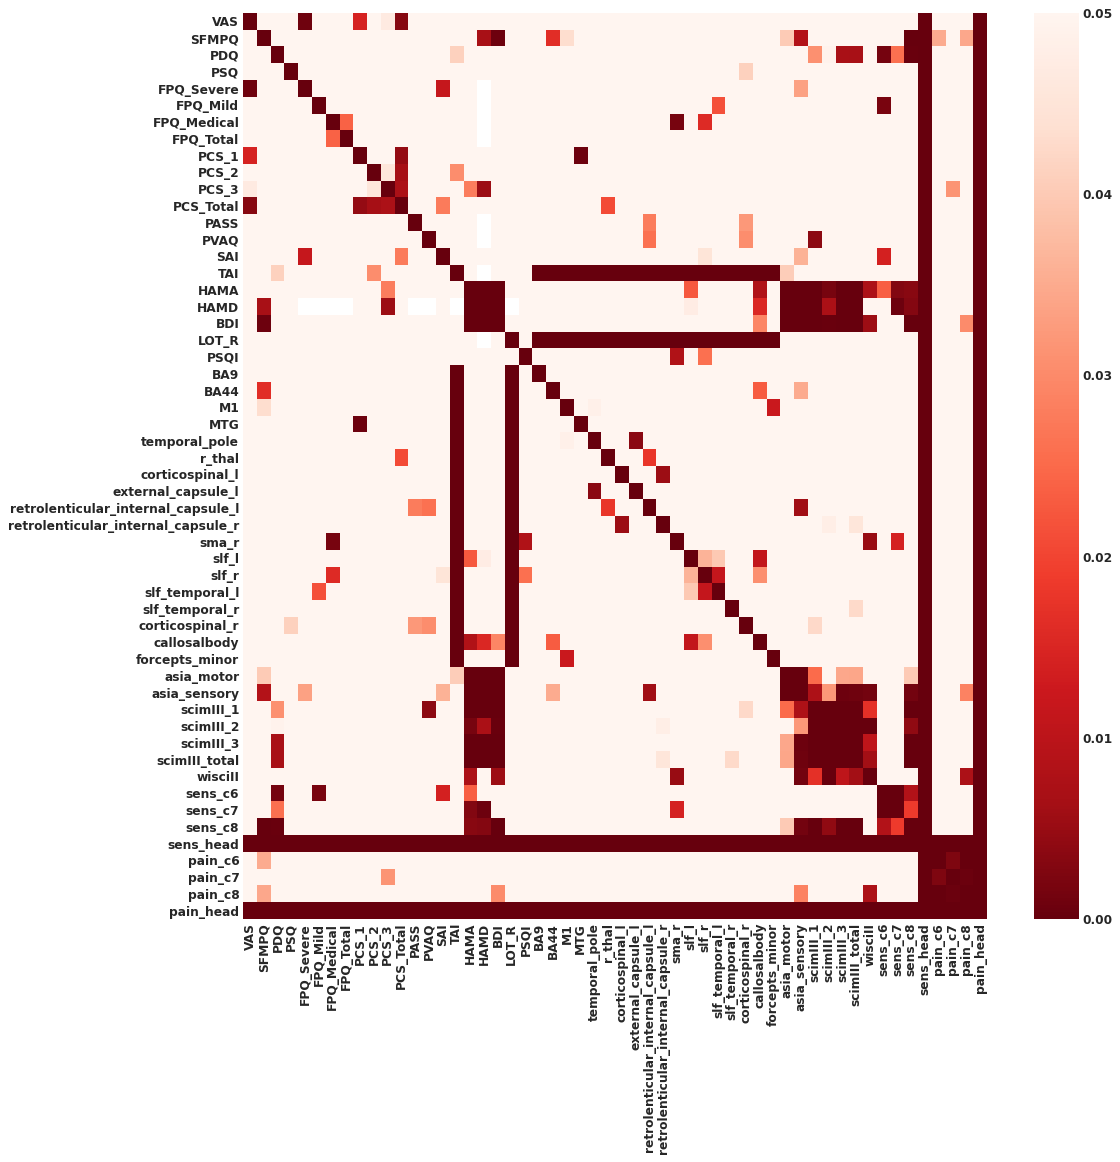

In [27]:
plt.figure(figsize=(15,15), dpi= 80)

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False 

sns.heatmap(vbm_p_matrix, cmap='Reds_r',vmax=0.05)

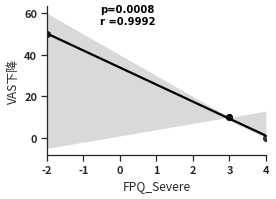

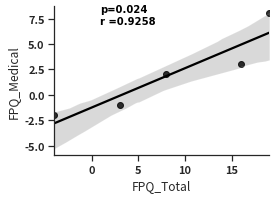

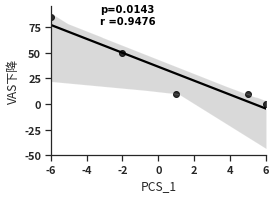

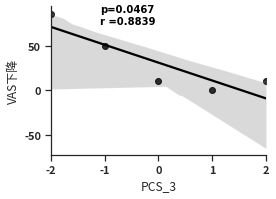

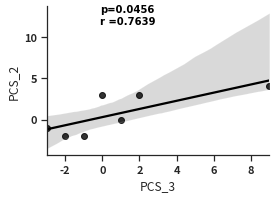

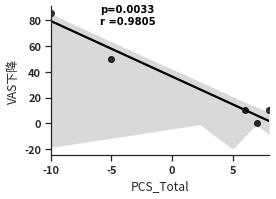

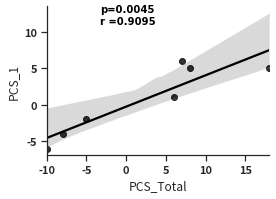

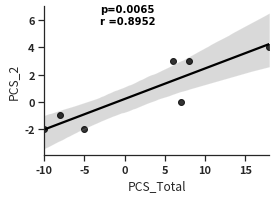

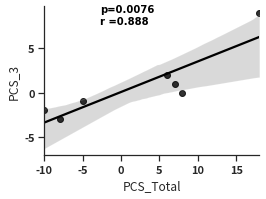

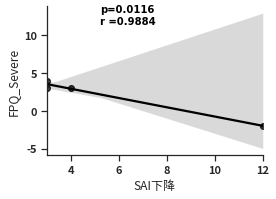

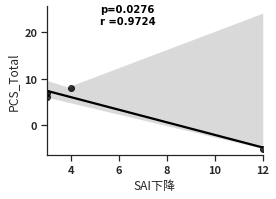

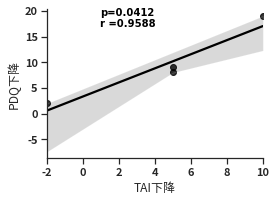

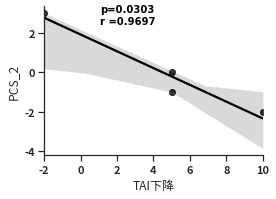

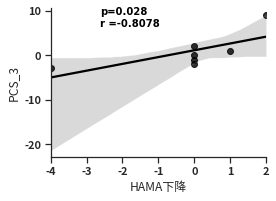

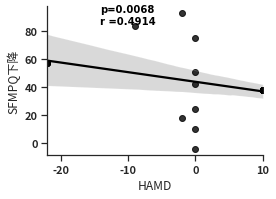

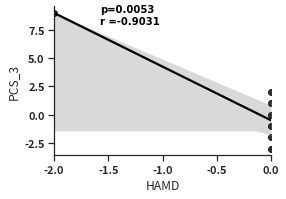

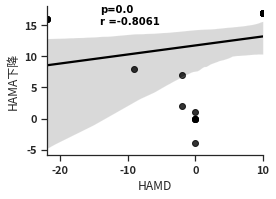

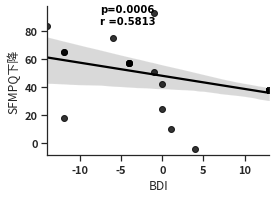

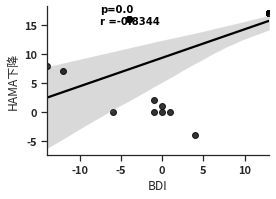

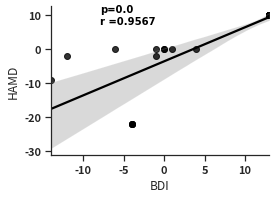

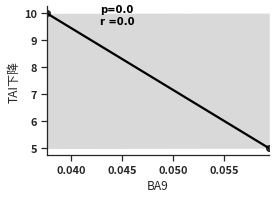

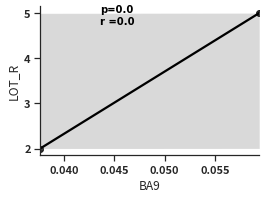

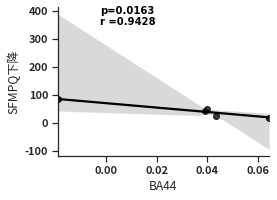

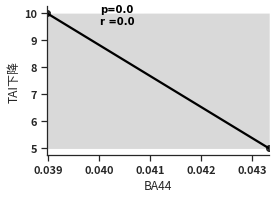

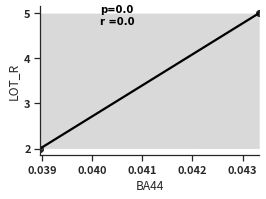

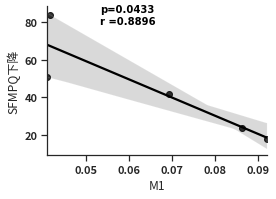

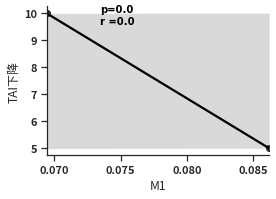

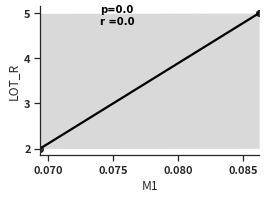

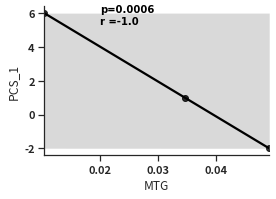

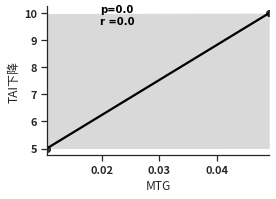

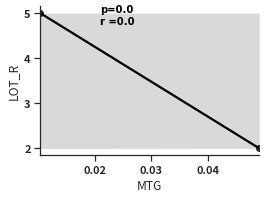

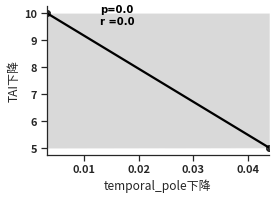

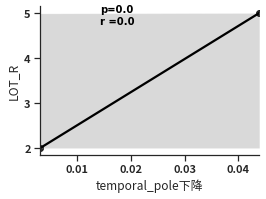

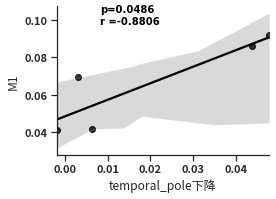

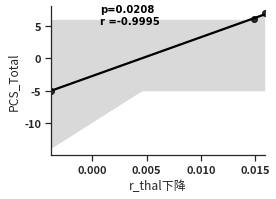

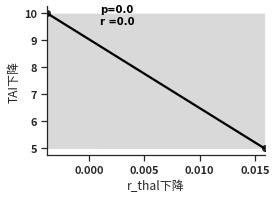

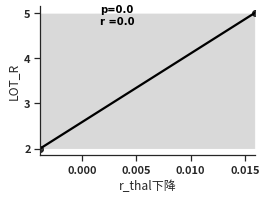

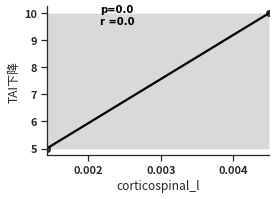

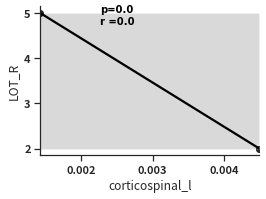

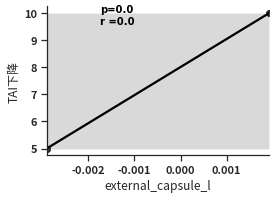

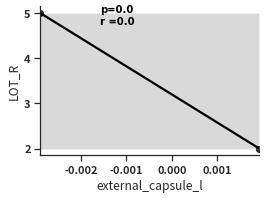

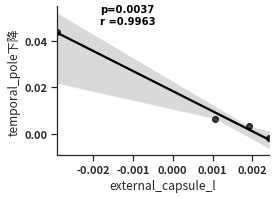

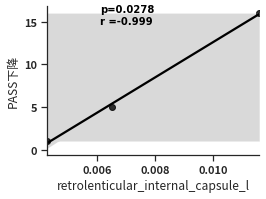

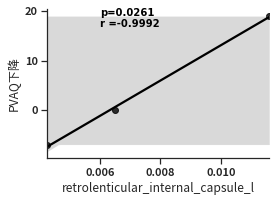

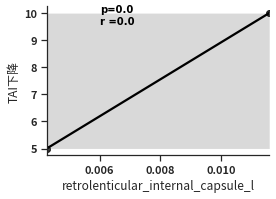

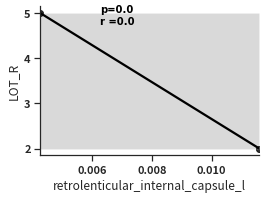

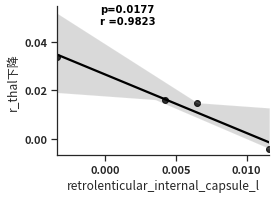

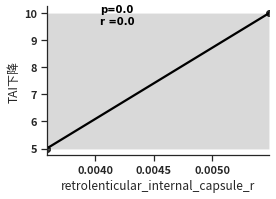

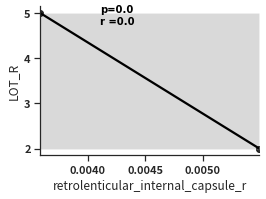

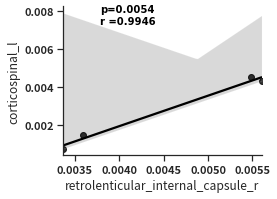

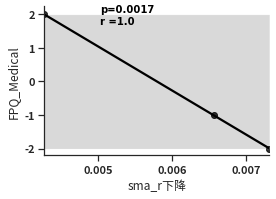

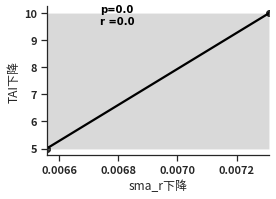

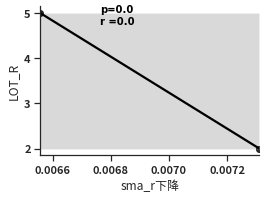

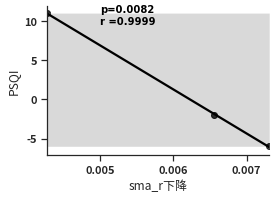

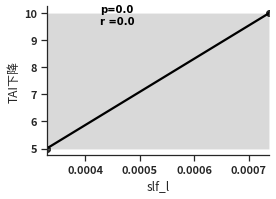

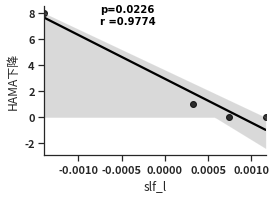

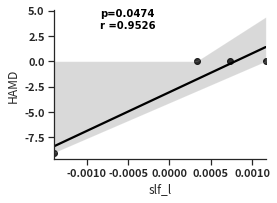

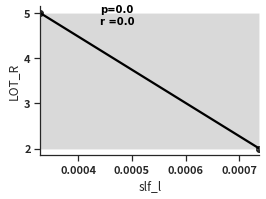

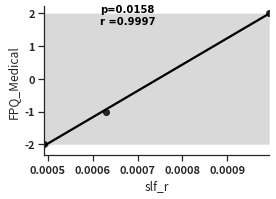

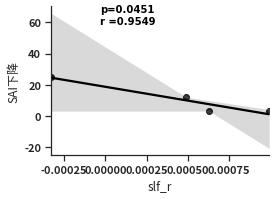

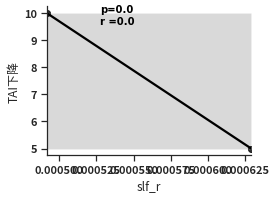

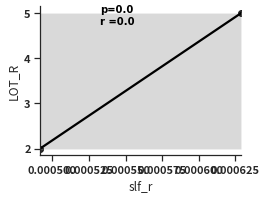

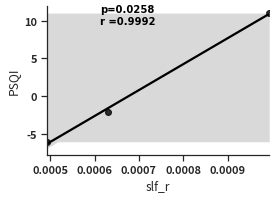

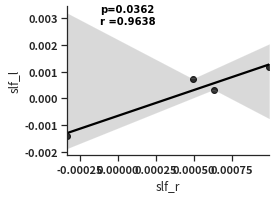

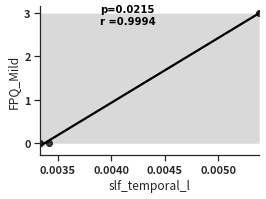

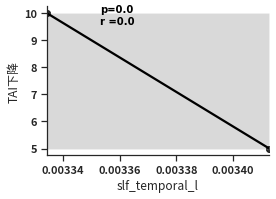

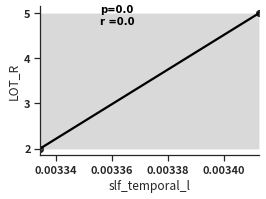

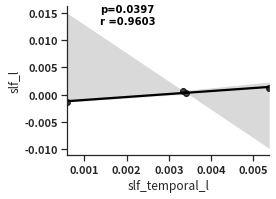

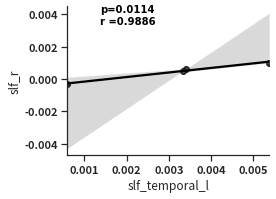

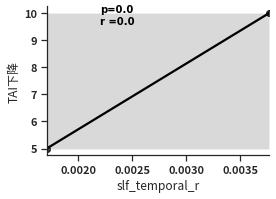

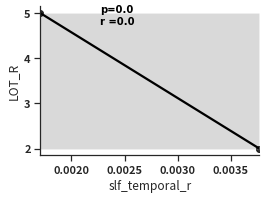

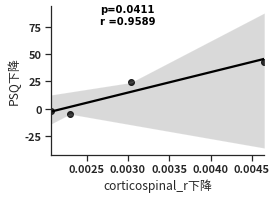

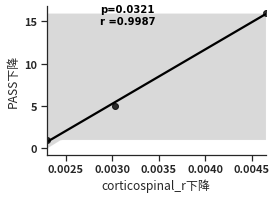

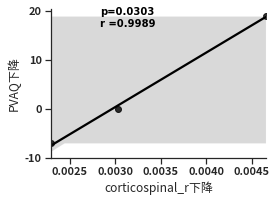

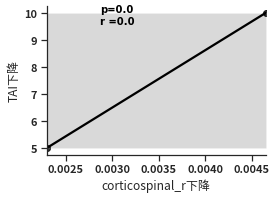

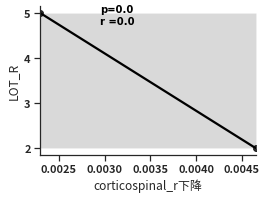

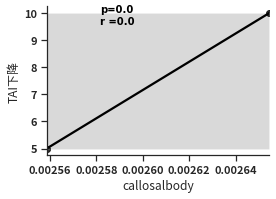

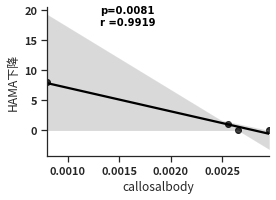

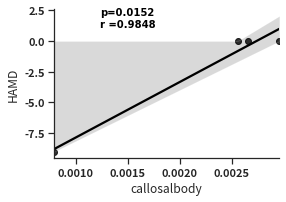

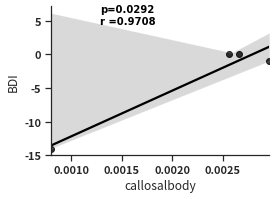

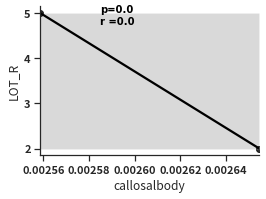

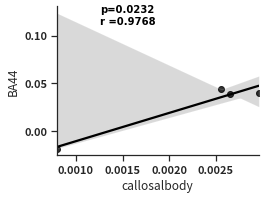

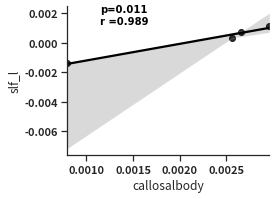

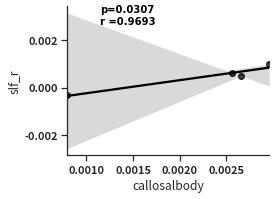

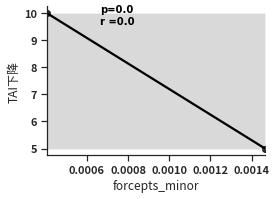

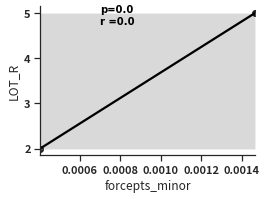

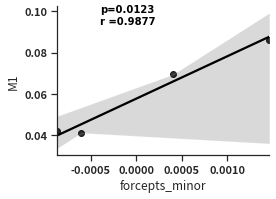

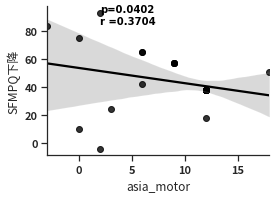

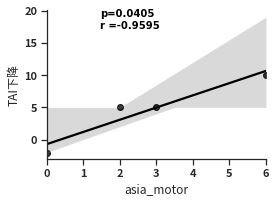

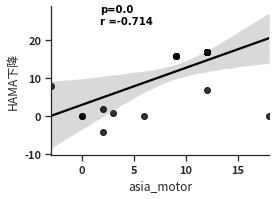

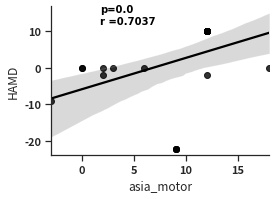

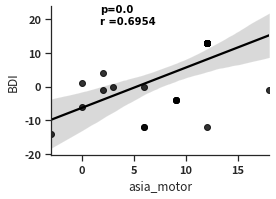

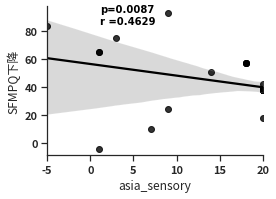

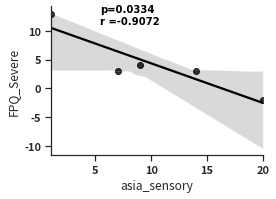

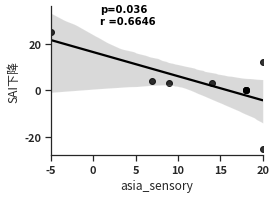

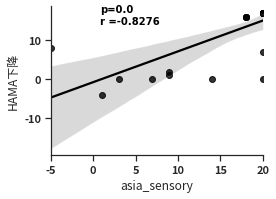

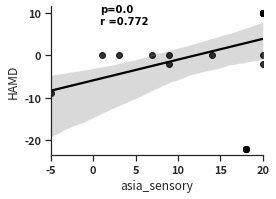

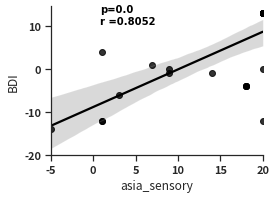

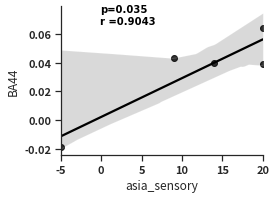

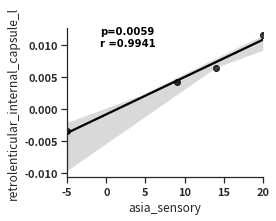

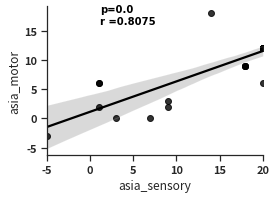

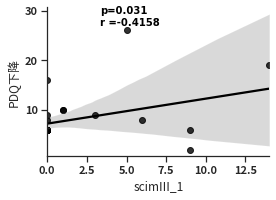

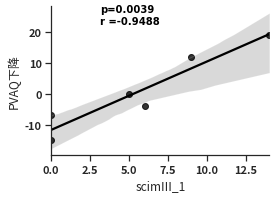

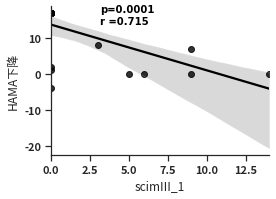

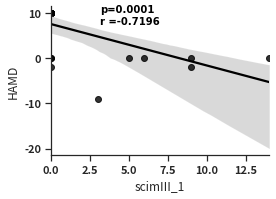

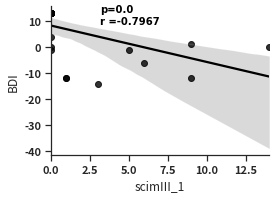

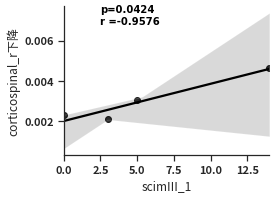

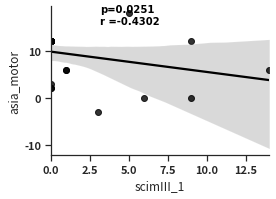

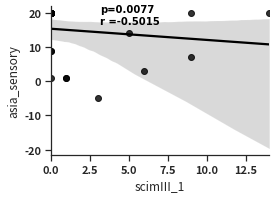

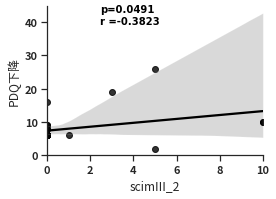

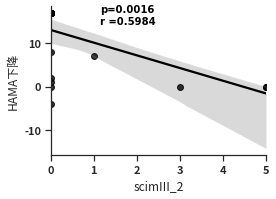

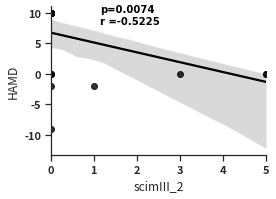

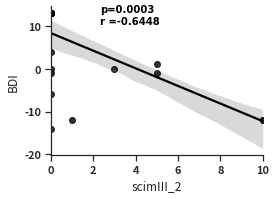

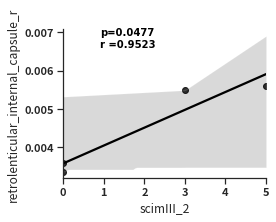

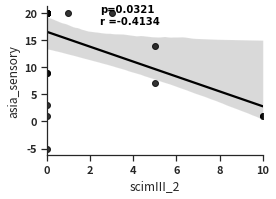

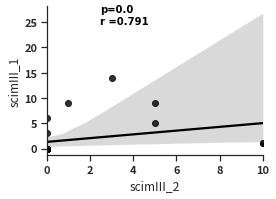

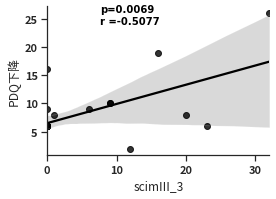

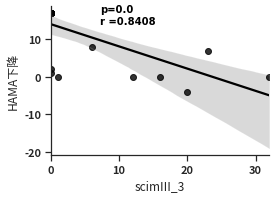

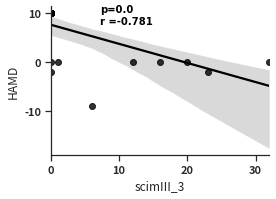

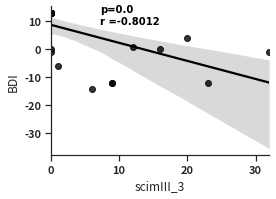

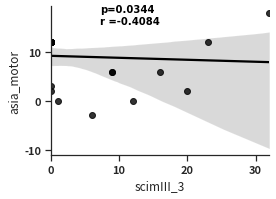

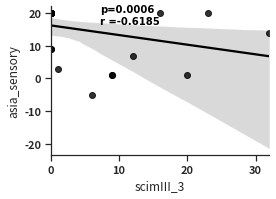

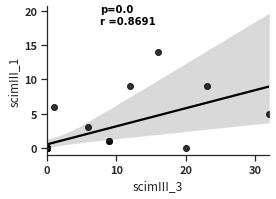

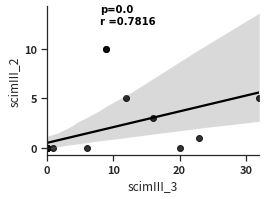

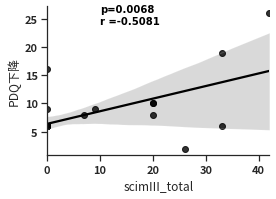

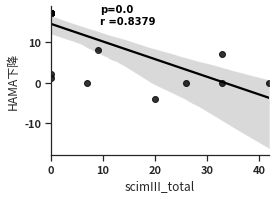

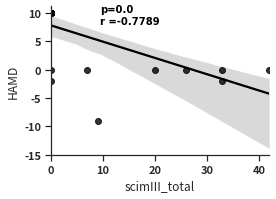

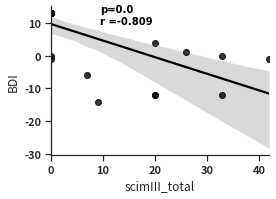

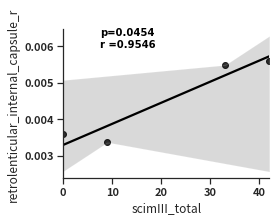

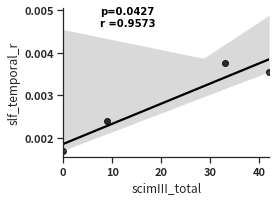

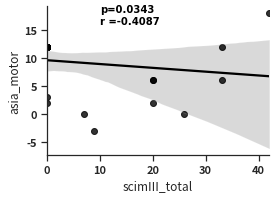

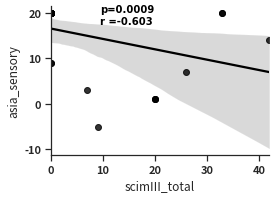

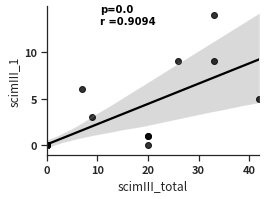

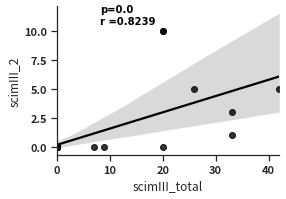

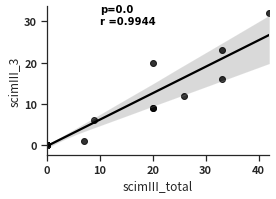

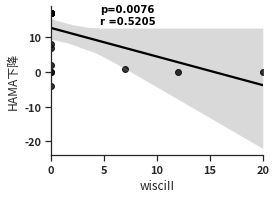

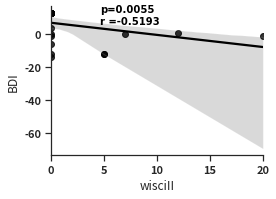

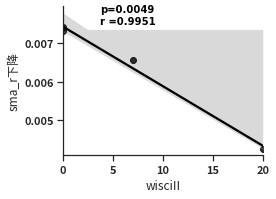

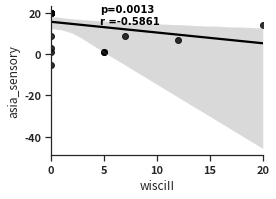

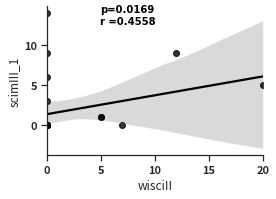

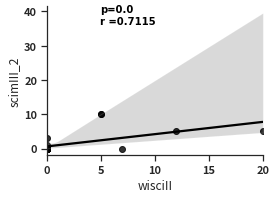

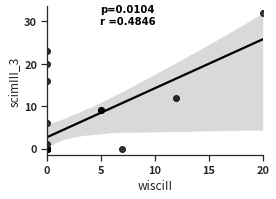

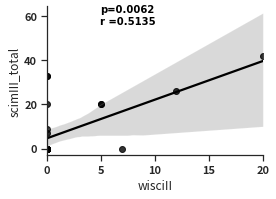

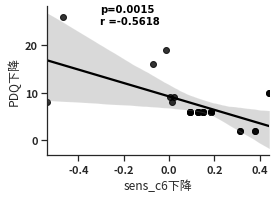

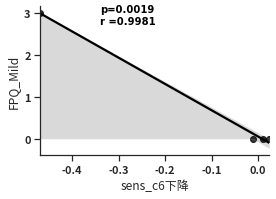

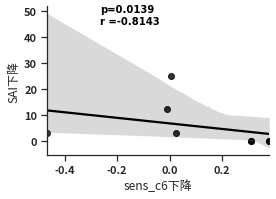

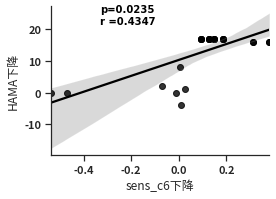

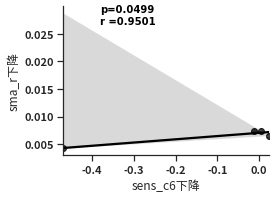

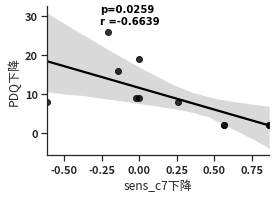

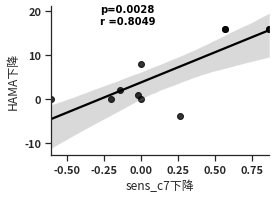

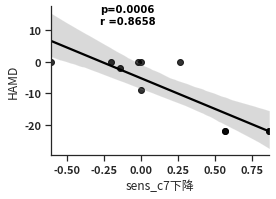

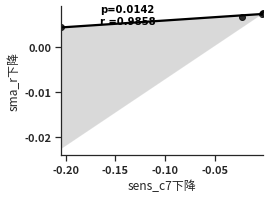

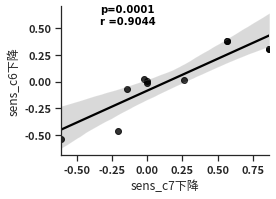

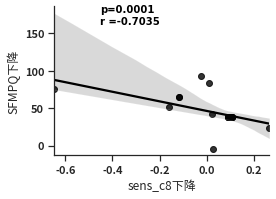

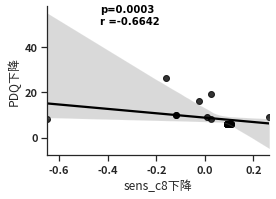

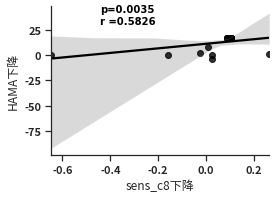

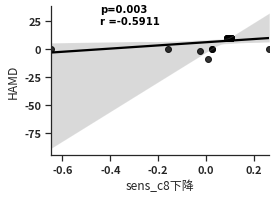

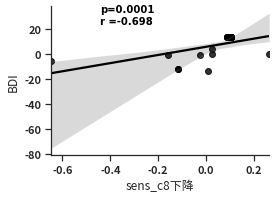

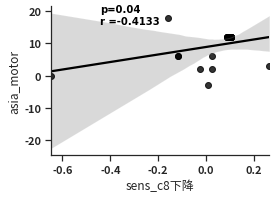

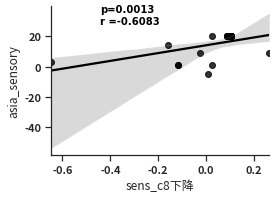

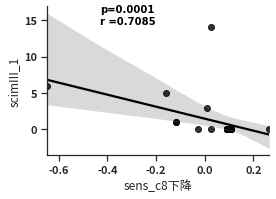

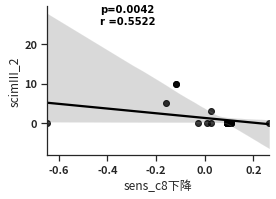

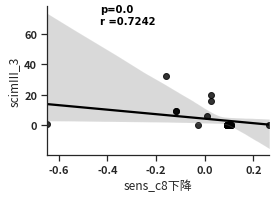

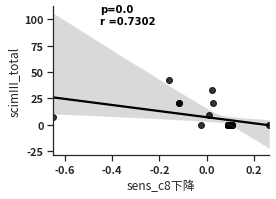

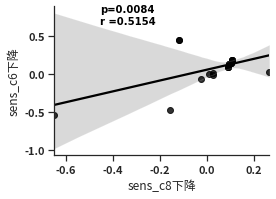

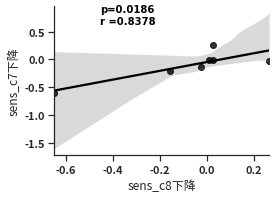

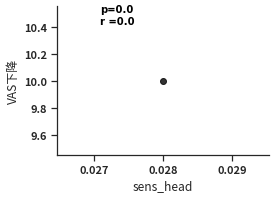

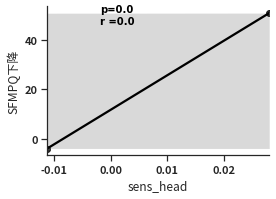

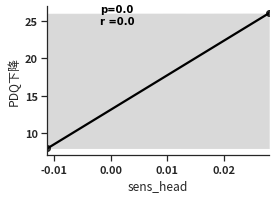

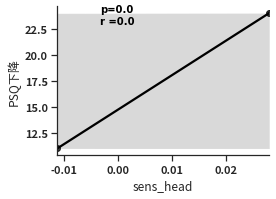

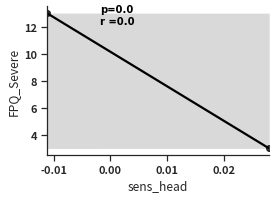

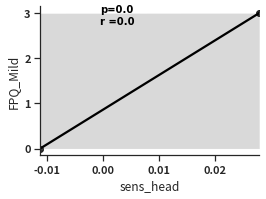

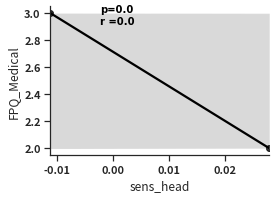

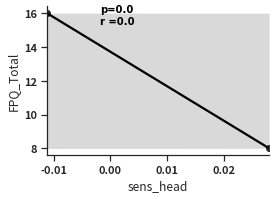

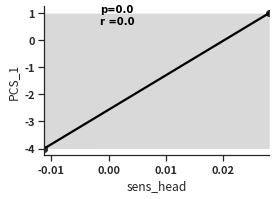

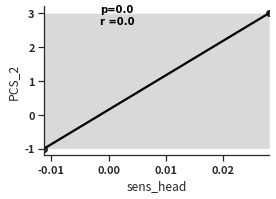

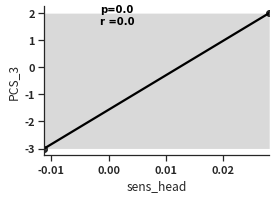

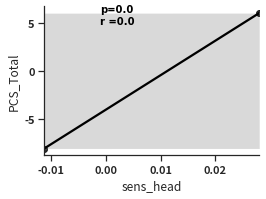

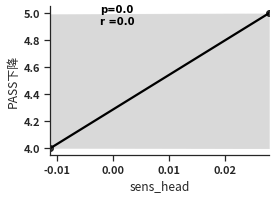

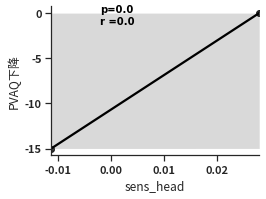

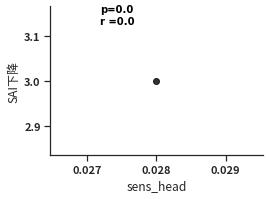

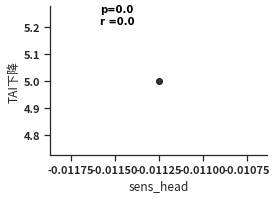

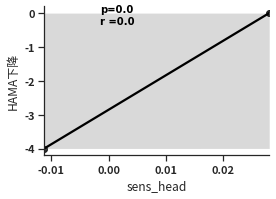

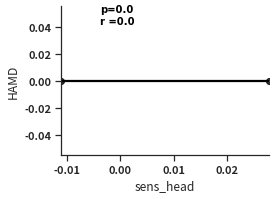

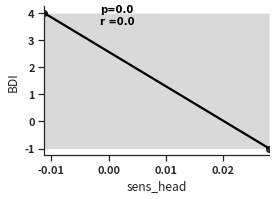

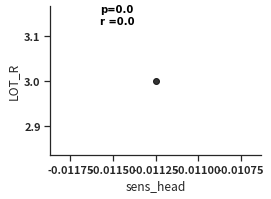

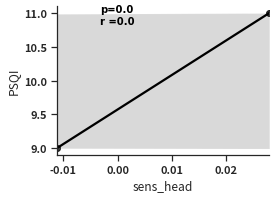

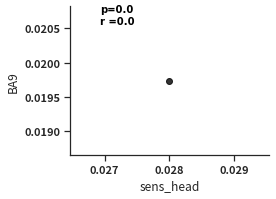

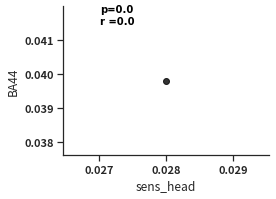

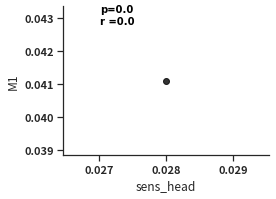

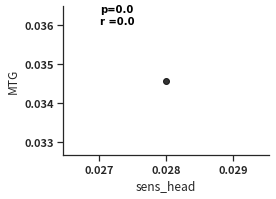

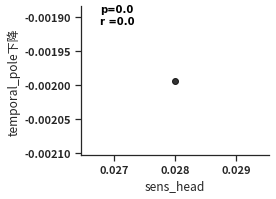

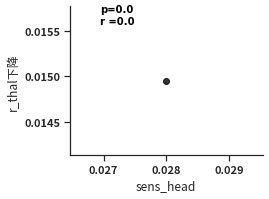

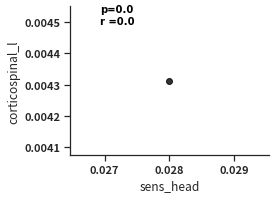

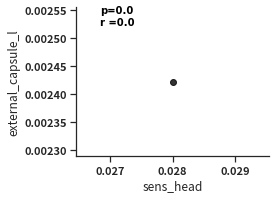

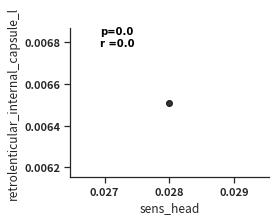

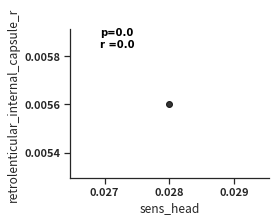

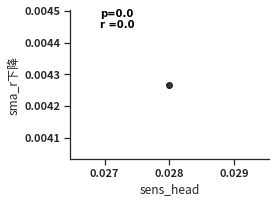

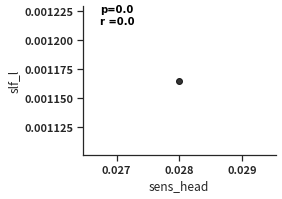

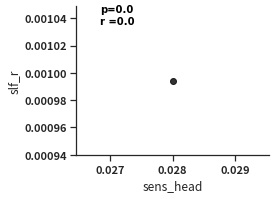

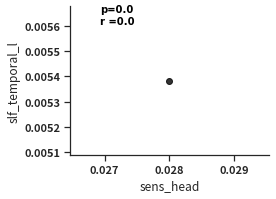

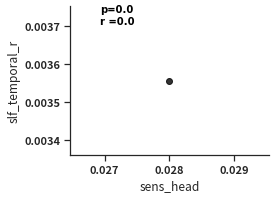

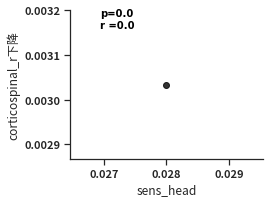

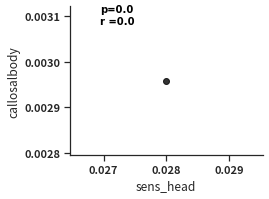

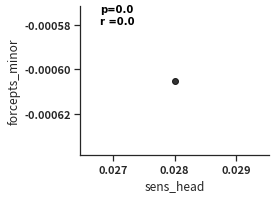

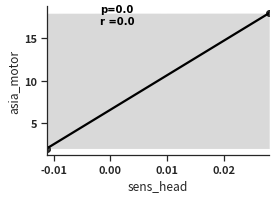

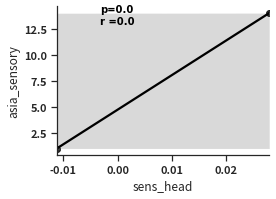

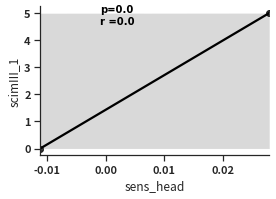

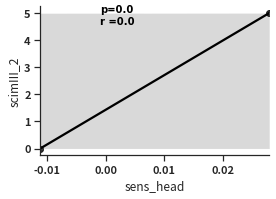

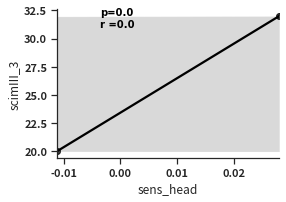

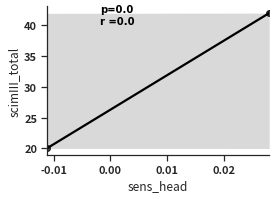

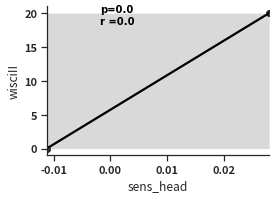

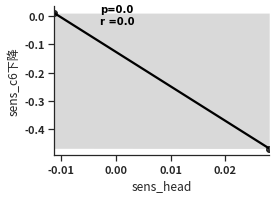

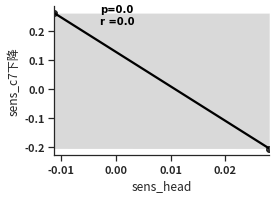

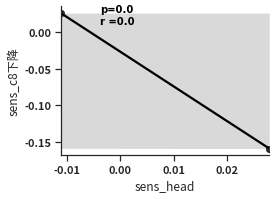

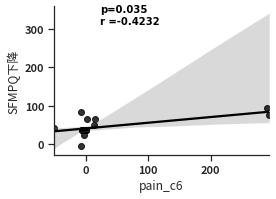

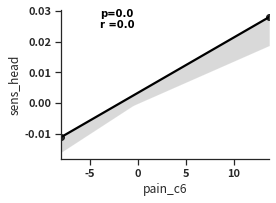

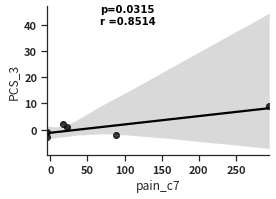

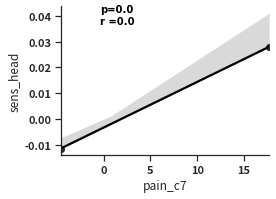

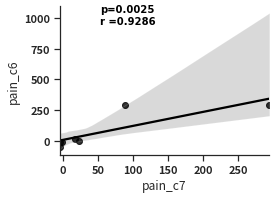

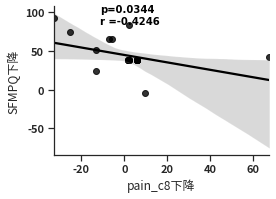

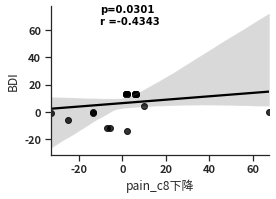

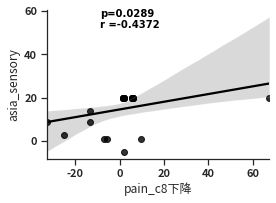

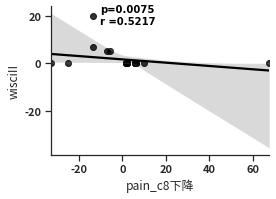

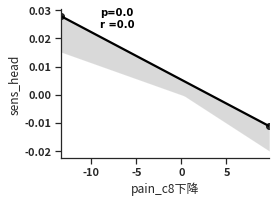

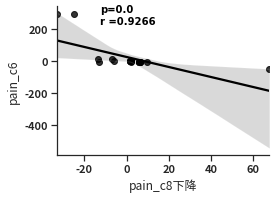

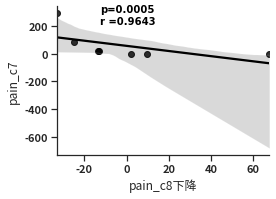

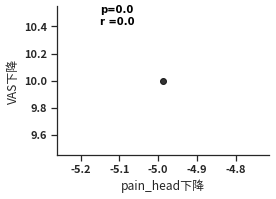

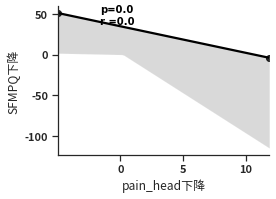

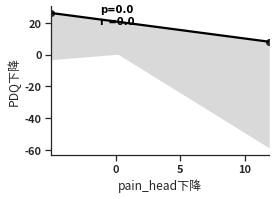

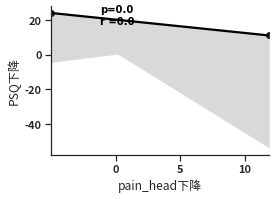

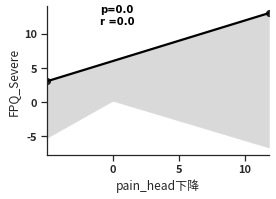

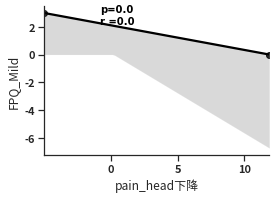

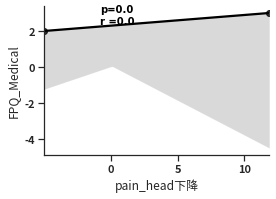

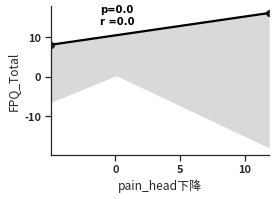

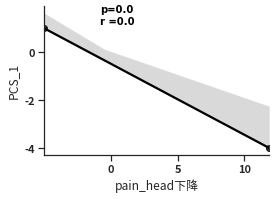

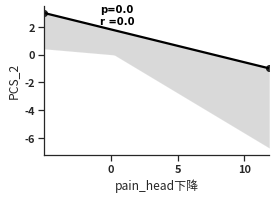

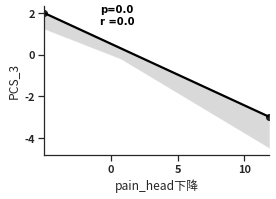

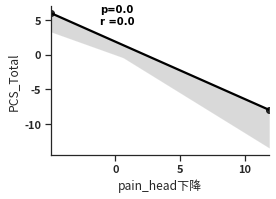

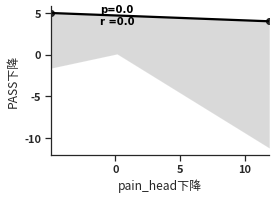

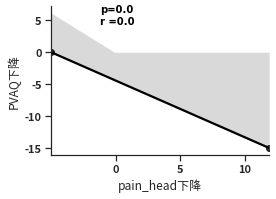

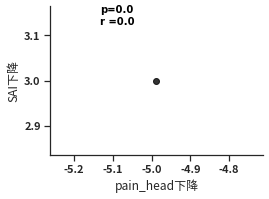

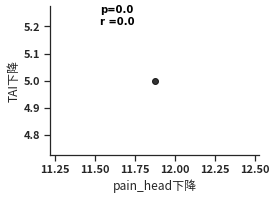

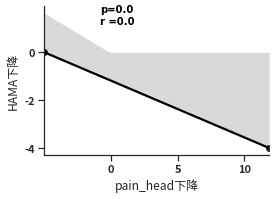

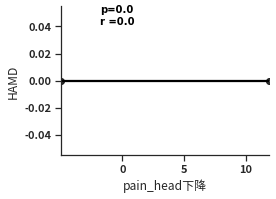

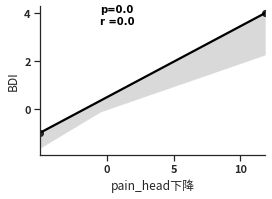

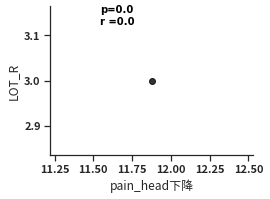

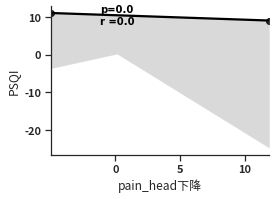

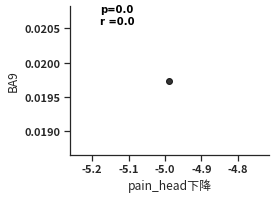

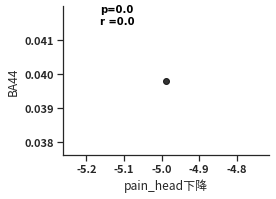

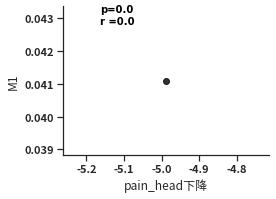

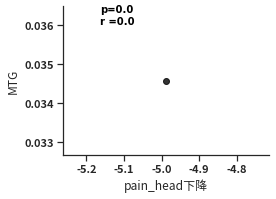

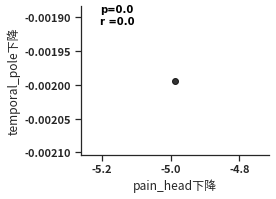

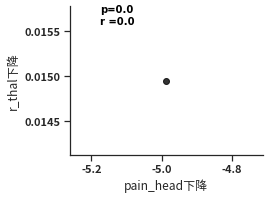

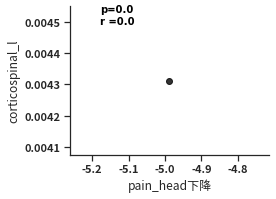

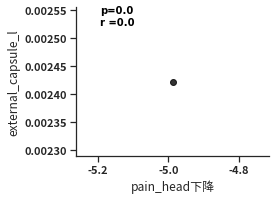

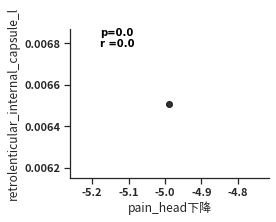

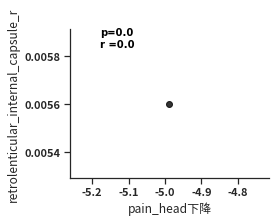

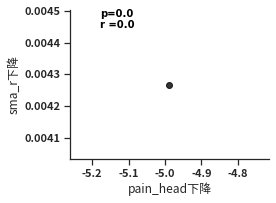

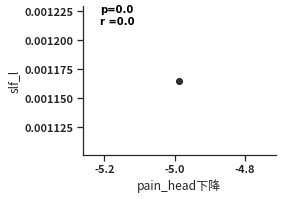

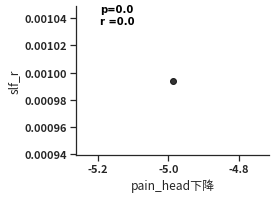

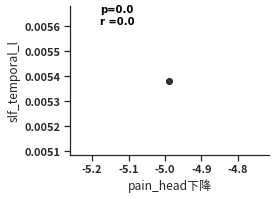

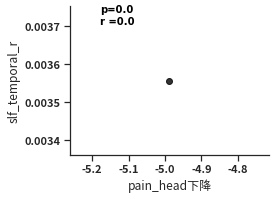

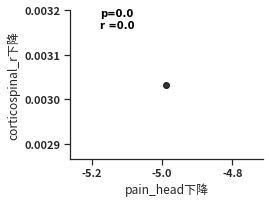

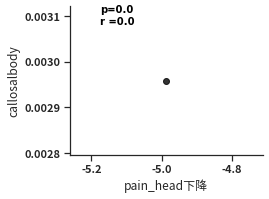

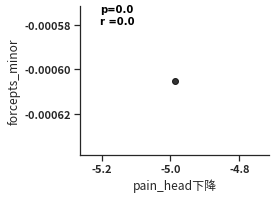

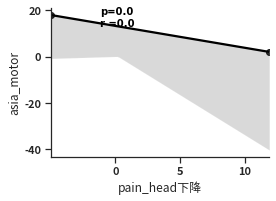

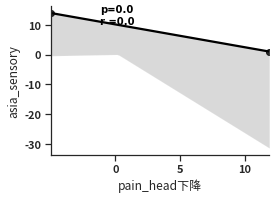

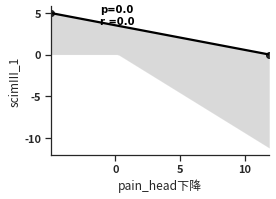

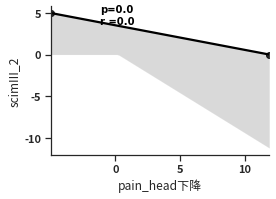

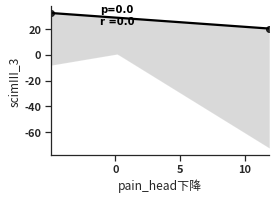

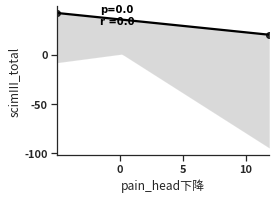

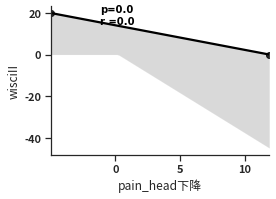

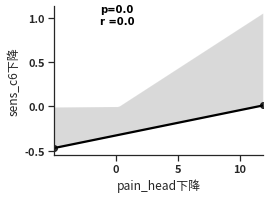

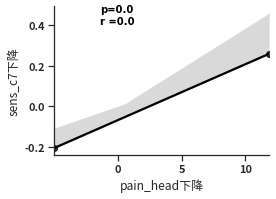

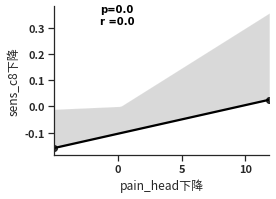

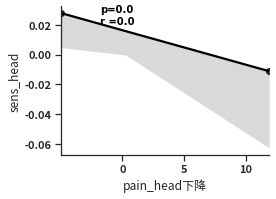

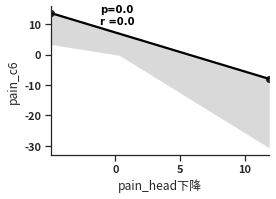

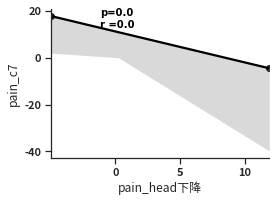

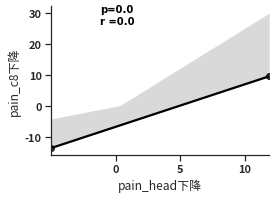

In [26]:
for i, scale in enumerate(test.columns):
    x_label = scale
    for j in range(i):
        y_label = test.columns[j]
        if x_label == y_label:
            continue
        if vbm_p_matrix.loc[y_label, x_label] < 0.05:

                plt.figure(figsize=(4,3))
                '''decorate image'''
                sns.set(font_scale=1)
                sns.set_style("white")
                plt.rcParams["font.weight"] = "bold"
                plt.rcParams["font.family"] = 'Noto Sans CJK JP'

                ax = plt.gca()      #gca='get current axis'
                # 将右边和上边的边框（脊）的颜色去掉
                ax.spines['right'].set_color('none')
                ax.spines['top'].set_color('none')

                # 绑定x轴和y轴
                font2 = {'weight' : 'normal','size'   : 10, }

                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                sns.set(color_codes=True)
                df_plot = test[[x_label, y_label]]
                y_axes = '' ; x_axes=''
                if df_plot[y_label].mean() < 0:
                    y_axes = '{}下降'.format(y_label)
                    df_plot[y_label] = - df_plot[y_label]
                if df_plot[x_label].mean() < 0:
                    x_axes = '{}下降'.format(x_label)
                    df_plot[x_label] = - df_plot[x_label]

                sns.regplot(x=x_label, y=y_label, data=df_plot,color='black')
                if x_axes:
                    plt.xlabel(x_axes) 
                if y_axes:
                    plt.ylabel(y_axes)
                if pccs[0] <= 0:
                    plt.annotate("p ={}\nr={}".format(round(vbm_p_matrix.loc[y_label, x_label],4),vbm_coefficient_matrix.loc[y_label, x_label])
                             , xy=(200, 175), xycoords='figure points',fontsize=10,color="black")
                else:
                    plt.annotate("p={}\nr ={}".format(round(vbm_p_matrix.loc[y_label, x_label],4),vbm_coefficient_matrix.loc[y_label, x_label])
                             , xy=(100, 175), xycoords='figure points',fontsize=10,color="black")
                plt.tight_layout()

                plt.show()

。。。